# Model plots for shark and ray meat landings and trade applied to 2014-2019 data

This plotting version pulls traces from clickhouse backend, using mcbackend

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pyt
import seaborn as sns
import pdb
from matplotlib.gridspec import GridSpec
import xarray as xr
import rdata as rd
import mcbackend
import clickhouse_driver

In [2]:
# Set figure style.
az.style.use("arviz-darkgrid")
bd = os.getcwd() + "/../Data/"
bf = os.getcwd() + "/../Figures/"

In [3]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo, Ix


# Helper functions
match = lambda a, b: np.array([b.index(x) if x in b else None for x in a])


def unique(series: pd.Series):
    "Helper function to sort and isolate unique values of a Pandas Series"
    return series.sort_values().unique()

# Load data

In [4]:
exec(open("Joint_Trade_Landings_Data.py").read())

Data loaded!


<string>:582: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:582: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:582: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:582: FutureWarning: The behavior of DataFrame concatenation with em

In [8]:
# Labels to pass in as needed for long country names
more_coords = {
    "Exporter": ("exporter", biggest_countries_long),
    "Importer": ("importer", biggest_countries_long)
}

# Import inference object

In [6]:
# Initialize clickhouse backend
ch_client = clickhouse_driver.Client("localhost")
# Connect to clickhouse using mcbackend
backend = mcbackend.ClickHouseBackend(ch_client)

In [7]:
# Fetch the most recent run from the database (downloads just metadata)
run = backend.get_run(backend.get_runs().index[-1])

In [10]:
# Function to pull variable from backend
def mcB_idata(BE,var_names,more_coords=None):
    tmp=BE.to_inferencedata(var_names=var_names)
    try:
        tmp.prior = tmp.prior.assign_coords(more_coords)
        tmp.prior_predictive = tmp.prior_predictive.assign_coords(more_coords)
        tmp.posterior = tmp.posterior.assign_coords(more_coords)
        tmp.posterior_predictive = tmp.posterior_predictive.assign_coords(more_coords)
        tmp.observed_data = tmp.observed_data.assign_coords(more_coords)
        tmp.constant_data = tmp.constant_data.assign_coords(more_coords)
    except:
        pass
    return tmp

In [ ]:
az.plot_trace(mcB_idata(run,var_names=["sigma"]).posterior)

In [7]:
# ArviZ doesn't handle MultiIndex yet
# Making it aware of the real data labeling at the obs level


"""
obs_idx_detailed = tdata_cut_sharks.set_index(["ISOex_i", "ISOim_j"]).index

more_coords = {
    "obs_idx": obs_idx_detailed,
    "ISOex_i": ("obs_idx", tdata_cut_sharks["ISOex_i"]),
    "ISOim_j": ("obs_idx", tdata_cut_sharks["ISOim_j"]),
}
"""

more_coords = {
    "Exporter": ("exporter", biggest_countries_long),
    "Importer": ("importer", biggest_countries_long)
}


idata_trade_x.prior = idata_trade_x.prior.assign_coords(more_coords)
idata_trade_x.prior_predictive = idata_trade_x.prior_predictive.assign_coords(more_coords)
idata_trade_x.posterior = idata_trade_x.posterior.assign_coords(more_coords)
idata_trade_x.posterior_predictive = idata_trade_x.posterior_predictive.assign_coords(more_coords)
idata_trade_x.observed_data = idata_trade_x.observed_data.assign_coords(more_coords)
idata_trade_x.constant_data = idata_trade_x.constant_data.assign_coords(more_coords)
#"""

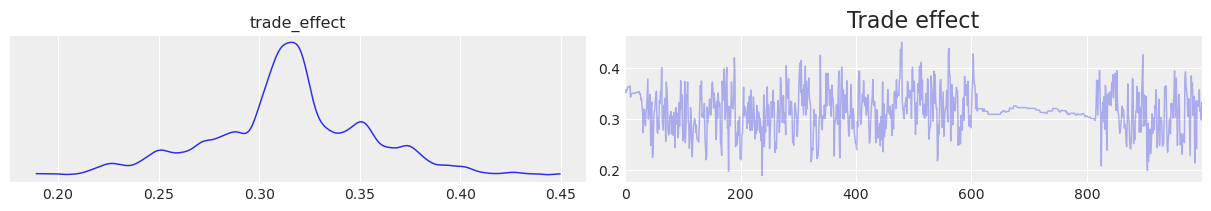

In [9]:
az.plot_trace(idata_trade_x.posterior["trade_effect"])
plt.title('Trade effect')
#plt.savefig(os.getcwd()+'/Figures/Posteriors/'+'Seafood_trade_effect.jpg',dpi=300);
plt.savefig('Seafood_trade_effect.jpg',dpi=300);

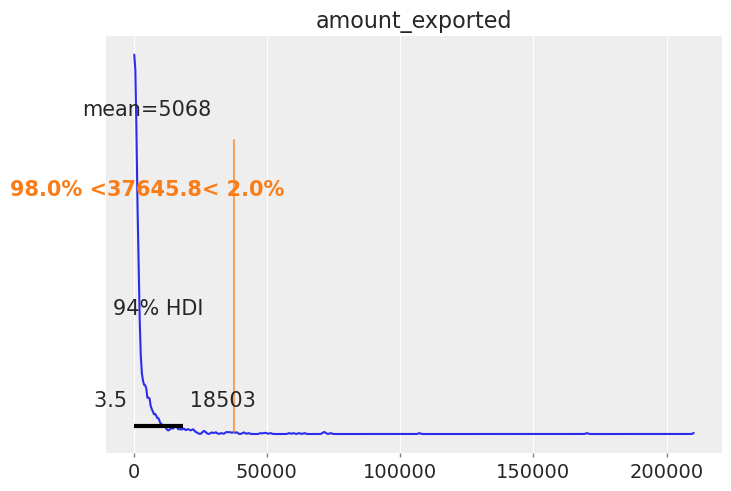

In [10]:
exz = 'URY'

az.plot_posterior(
    idata_trade_x.posterior["amount_exported"].sel(importer="BRA", exporter=exz).sum("species"),
    ref_val=tdata_cut_sharks.loc[(tdata_cut_sharks.ISOex_i==exz) & (tdata_cut_sharks.ISOim_j=='BRA'), "estimated_live_weight"].to_list(),
)
plt.savefig('Uruguay_to_Brazil_trade_effect.jpg',dpi=300);

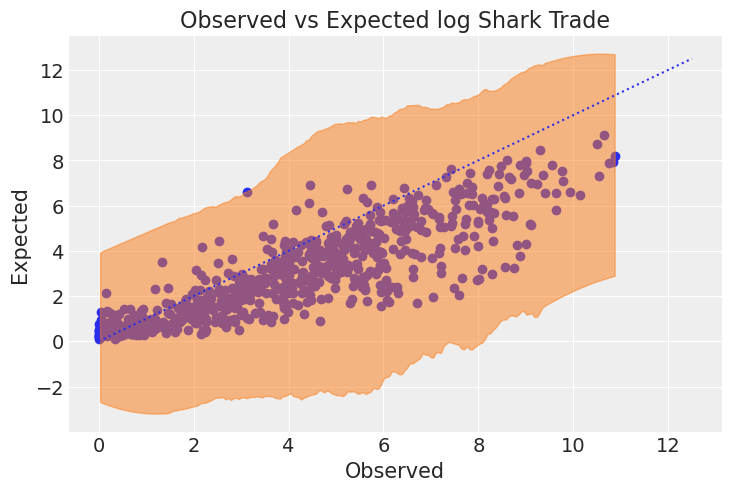

In [11]:
#"""
mu_pp = idata_trade_x.posterior_predictive["log_shark_trade"]
_, ax = plt.subplots()
ax.scatter(idata_trade_x.observed_data["log_shark_trade"], mu_pp.mean(("chain", "draw")))
az.plot_hdi(idata_trade_x.observed_data["log_shark_trade"], mu_pp)
ax.plot((0,12.5),(0,12.5),linestyle=":")
ax.set_xlabel("Observed")
ax.set_ylabel("Expected")
ax.set_title("Observed vs Expected log Shark Trade")
plt.savefig(bf+'/Diagnostics/Observed_vs_Expected_log_shark_trade.jpg',dpi=300)
#plt.close()
#"""

In [12]:
diffx = (idata_trade_x.observed_data["log_shark_trade"]-mu_pp.mean(("chain", "draw"))).to_numpy()
tdata_cut_sharks['diff'] = diffx

In [13]:
# Check for log-scale within-sample differences
tdata_cut_sharks[abs(diffx)>1].sort_values(['diff'])

ISOex_i ISOim_j  hscode_k  year_t  exporter_i  importer_j   value_v  \
45      BRA     KOR     30381    2017          76         410    22.474   
7       ARG     CHN     30381    6039          96         468   120.894   
512     PRT     BEL     60662    6046        1860         168     6.719   
250     IDN     KOR     30381    8059        1440        1640     9.204   
583     THA     KOR     30381    2014         764         410     0.247   
..      ...     ...       ...     ...         ...         ...       ...   
601     TWN     HKG     30381   12087        2940        2064  6124.142   
611     TWN     SGP     30381   12087        2940        4212  3624.381   
612     TWN     THA     30381   12087        2940        4584  2356.026   
477     PAN     CRI     30381   12087        3546        1128  5155.018   
555     SGP     CHN     30381   12087        4212         936  9045.165   

     quantity_q  estimated_live_weight     fish_type      diff  
45       10.880              21.760000        sharks -3.468470  
7        42.644              85.288000        sharks -2.445662  
512       1.818               2.817143  sharkssharks -2.166077  
250       3.900               7.800000        sharks -1.995089  
583       0.079               0.158000        sharks -1.990199  
..          ...                    ...           ...       ...  
601    1444.534            2889.068000        sharks  5.279552  
611    2585.038            5170.076000        sharks  5.288027  
612    1999.884            3999.768000        sharks  5.308822  
477    3852.530            6267.065569        sharks  5.492713  
555    2013.365            1998.239836        sharks  5.563464  

[344 rows x 11 columns]

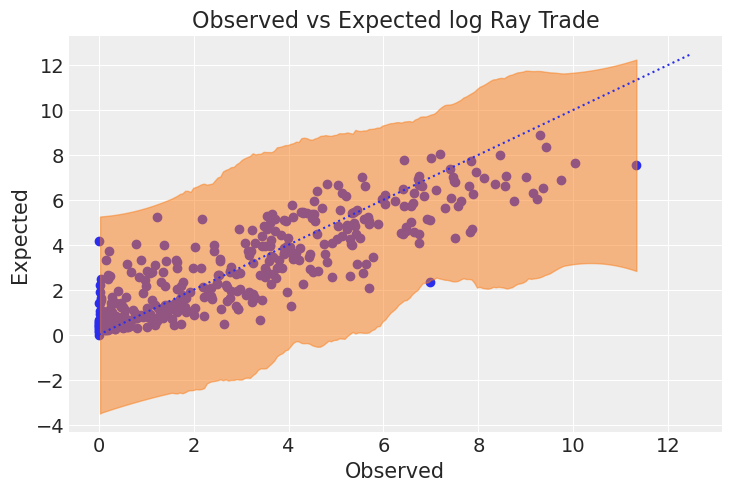

In [14]:
#"""
mu_pp = idata_trade_x.posterior_predictive["log_ray_trade"]
_, ax = plt.subplots()
ax.scatter(idata_trade_x.observed_data["log_ray_trade"], mu_pp.mean(("chain", "draw")))
az.plot_hdi(idata_trade_x.observed_data["log_ray_trade"], mu_pp)
ax.plot((0,12.5),(0,12.5),linestyle=":")
ax.set_xlabel("Observed")
ax.set_ylabel("Expected")
ax.set_title("Observed vs Expected log Ray Trade")
#plt.savefig(os.getcwd()+'/Figures/Diagnostics/'+'Observed_vs_Expected_log_ray_trade.jpg',dpi=300);
plt.savefig('Observed_vs_Expected_log_ray_trade.jpg',dpi=300);
#"""

# Plot species affinities by country

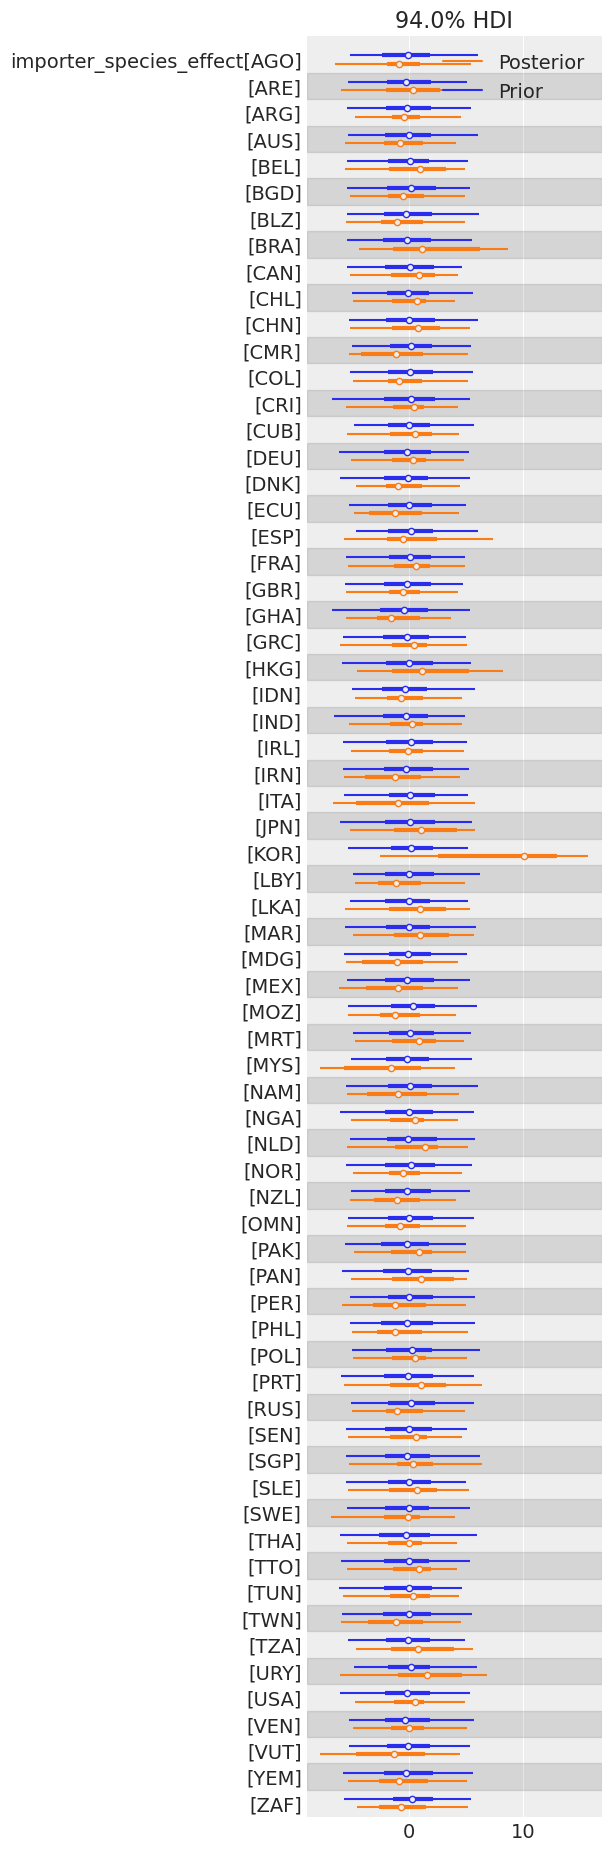

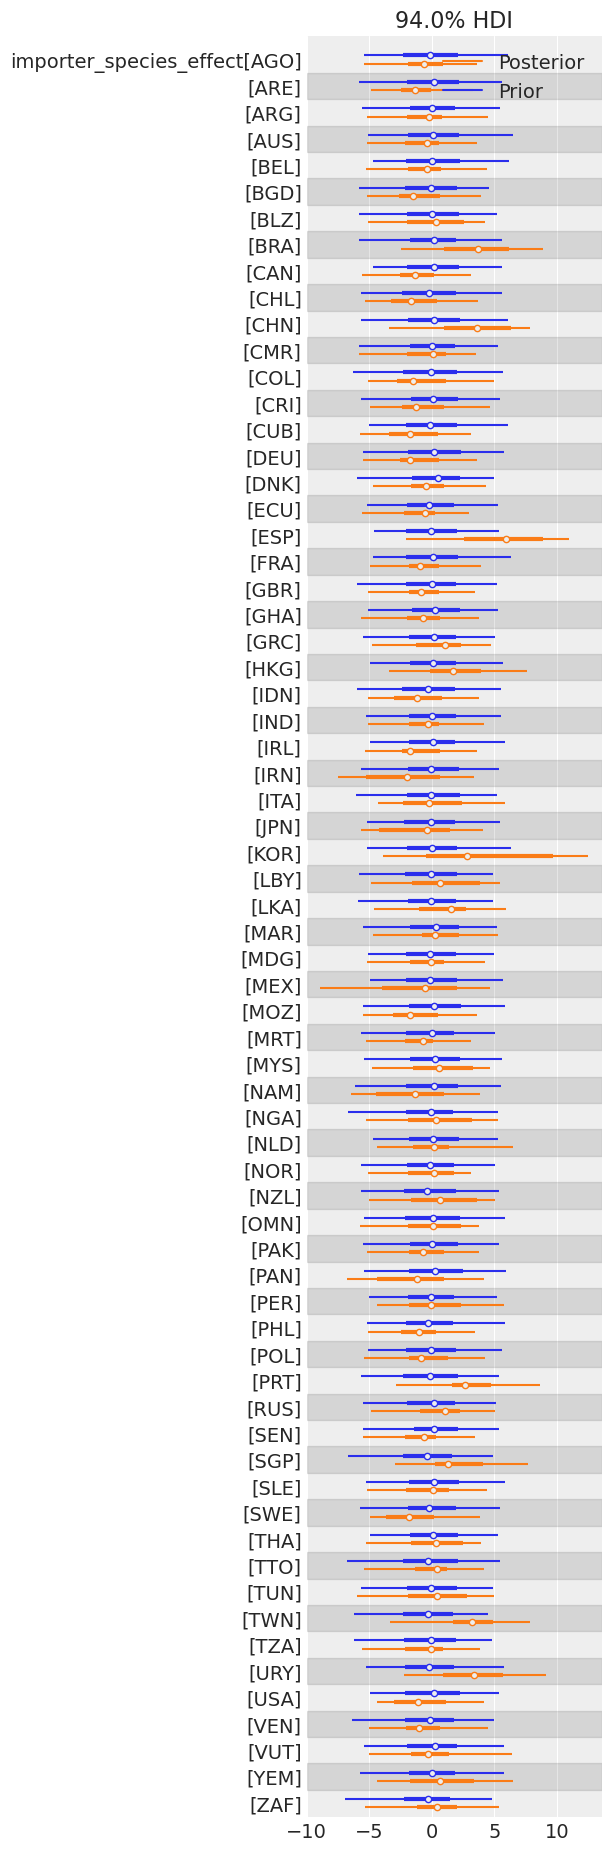

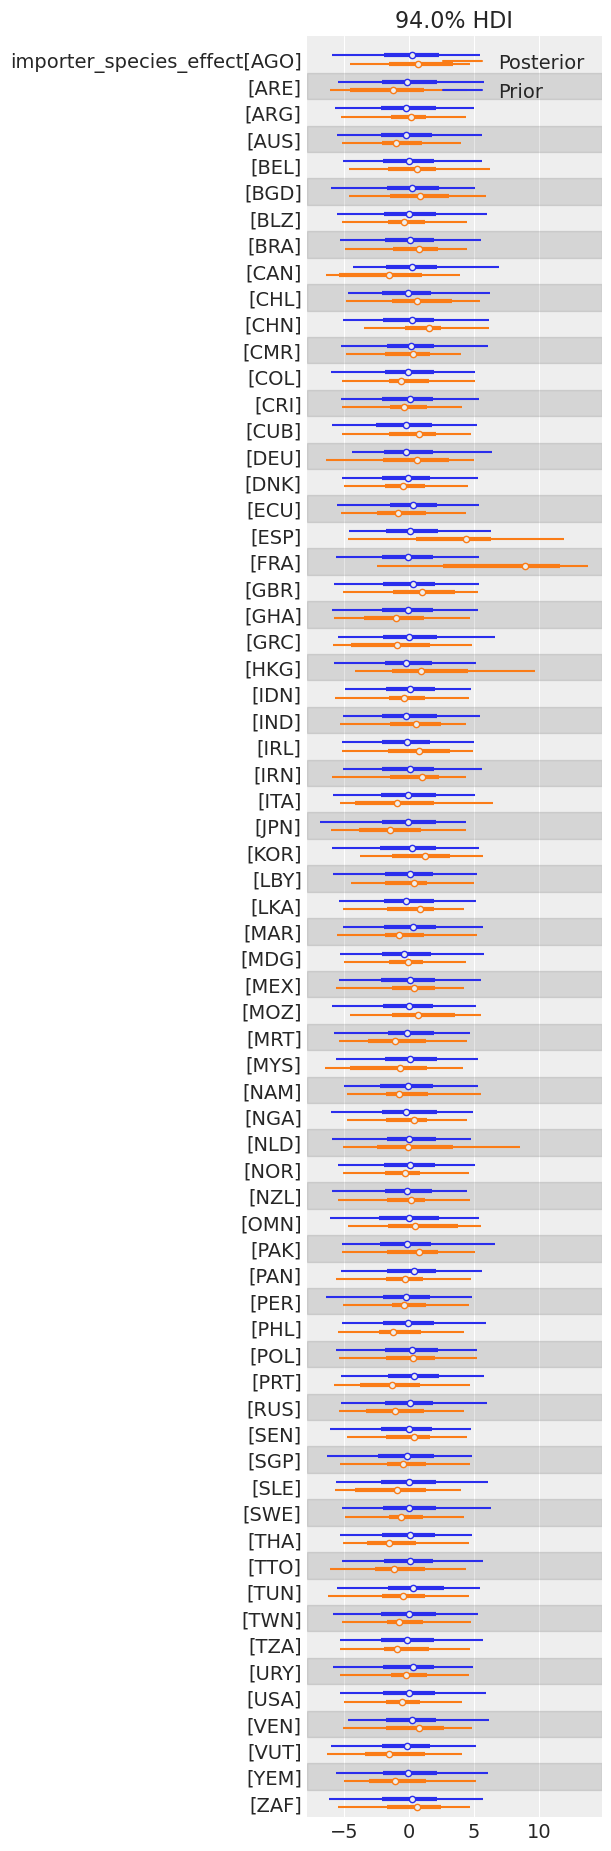

In [21]:
for spp in idata_trade_x.posterior["importer_species_effect"].mean(("chain")).species.to_numpy():
    # Grab posteriors for species
    tmp = idata_trade_x.posterior["importer_species_effect"].mean(("chain")).sel(species=spp).to_numpy()
    # If >75% HPD beyond zero, plot it
    if sum((np.quantile(tmp,0.25,axis=0)>0)*1+(np.quantile(tmp,0.75,axis=0)<0)*1)>0:
        az.plot_forest(
            [idata_trade_x.prior, idata_trade_x.posterior],
            model_names=["Prior", "Posterior"],
            var_names="importer_species_effect",
            coords={"species":spp},
            combined=True,
            #figsize=(10, 5),
            )

        #plt.savefig(os.getcwd()+'/Figures/Species/'+spp+'_importer_affinity.jpg',dpi=300)
        #plt.close()
    else:
        pass

## Plot trade by species

In [74]:
""""
for sppx in species_:

    post_latent_trade = (
        idata_trade_x.posterior["amount_exported"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                        "Importer": ("importer", biggest_countries_long)})
        .drop_vars(['exporter','importer'])
        .sel(species=sppx)
    )

    _, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(
        post_latent_trade.to_dataframe().drop(["species"], axis="columns")
        .reset_index().drop(['exporter','importer'],axis=1)
        .set_index(['Exporter','Importer']).unstack()
        .droplevel(0, axis=1)
        .T,
        ax=ax,
        cmap=sns.color_palette("Blues", as_cmap=True),
    )
    ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
    ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

    ax.set_title("Average latent trade\n"+sppx, fontsize=30)
    ax.set_xlabel("Exporter", fontsize=30)
    ax.set_ylabel("Importer", fontsize=30)
    
    plt.savefig(os.getcwd()+'/Figures/Species/'+sppx+'_latent_trade_grid.jpg',dpi=300)
    plt.close()
#"""

'"\nfor sppx in species_:\n\n    post_latent_trade = (\n        idata_trade_x.posterior["amount_exported"]\n        .median(("chain", "draw"))\n        .assign_coords({"Exporter": ("exporter", biggest_countries_long),\n                        "Importer": ("importer", biggest_countries_long)})\n        .drop_vars([\'exporter\',\'importer\'])\n        .sel(species=sppx)\n    )\n\n    _, ax = plt.subplots(figsize=(20, 15))\n    sns.heatmap(\n        post_latent_trade.to_dataframe().drop(["species"], axis="columns")\n        .reset_index().drop([\'exporter\',\'importer\'],axis=1)\n        .set_index([\'Exporter\',\'Importer\']).unstack()\n        .droplevel(0, axis=1)\n        .T,\n        ax=ax,\n        cmap=sns.color_palette("Blues", as_cmap=True),\n    )\n    ax.hlines(range(ncou),xmin=0,xmax=ncou,color=\'grey\',alpha=0.1)\n    ax.vlines(range(ncou),ymin=0,ymax=ncou,color=\'grey\',alpha=0.1)\n\n    ax.set_title("Average latent trade\n"+sppx, fontsize=30)\n    ax.set_xlabel("Exporter", 

## Plot residual trade by Dyad pair

Text(-1.3885555555555573, 0.5, 'Importer')

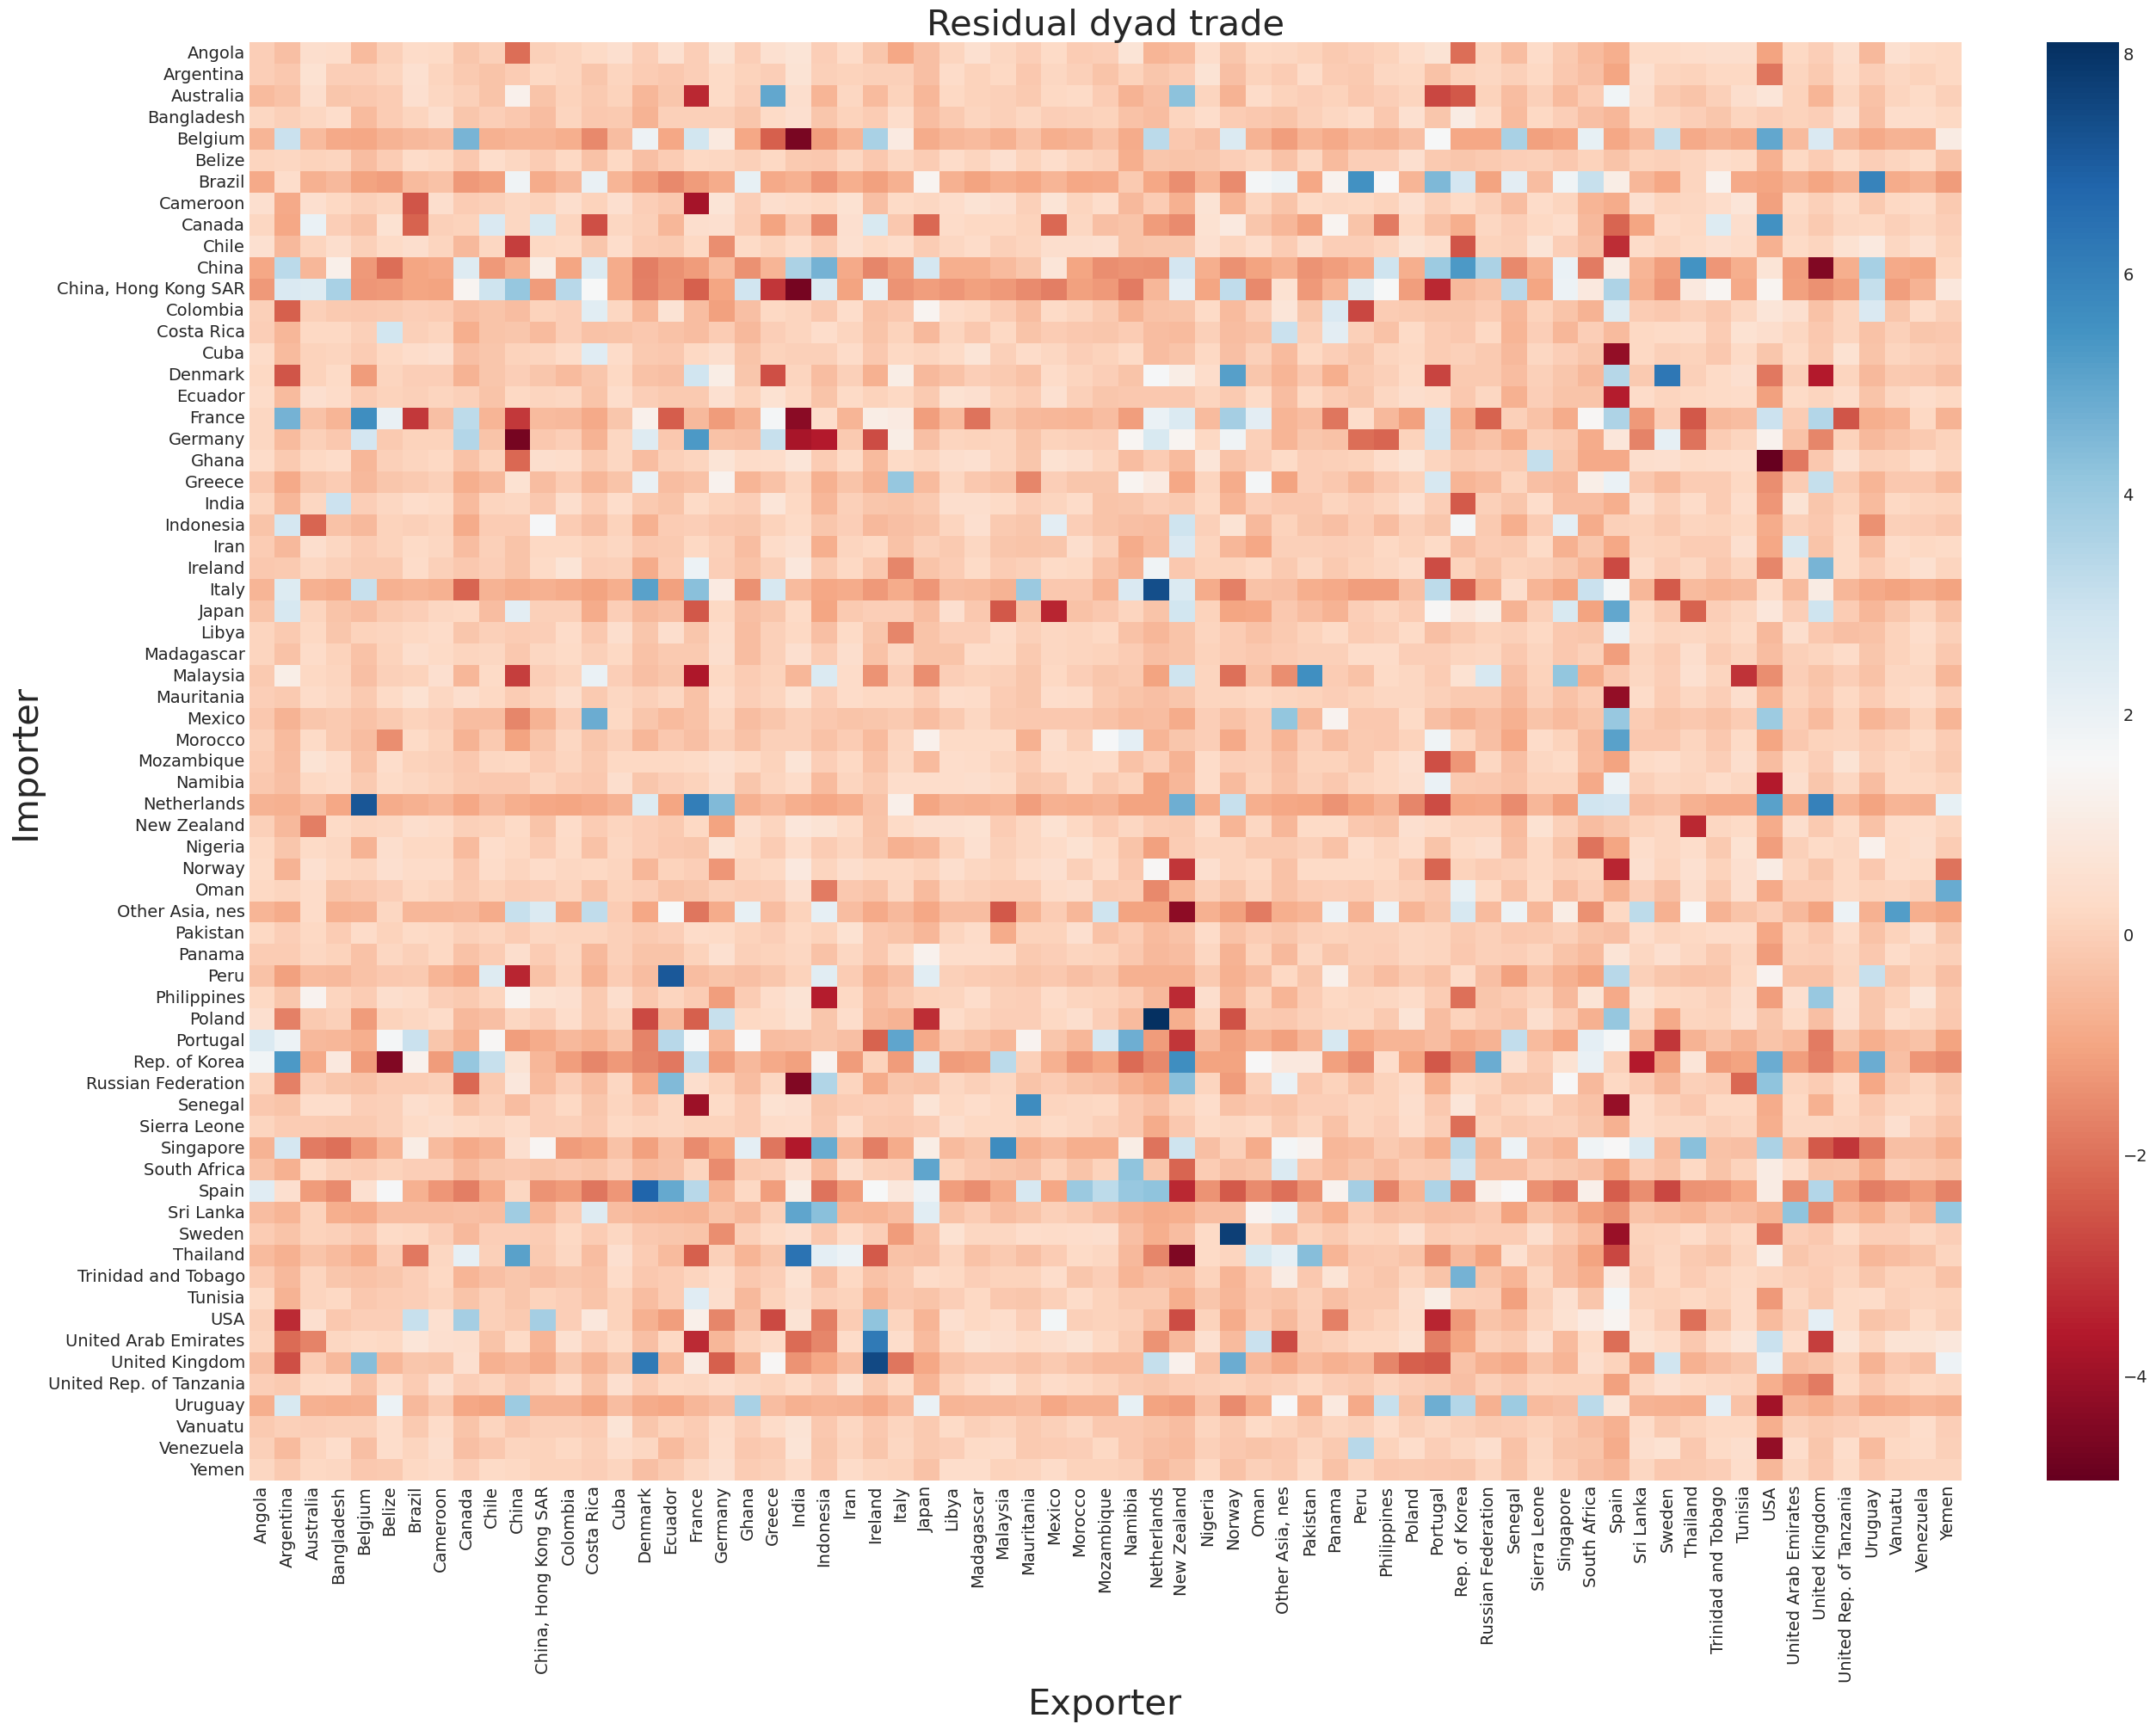

In [25]:
post_dyad = (
    idata_trade_x.posterior["dyad_effect"]
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
        "Importer": ("importer", biggest_countries_long)})
    .drop_vars(['exporter','importer'])
).to_dataframe()

_, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(
    post_dyad
        .reset_index().drop(['exporter','importer'],axis=1)
        .set_index(['Exporter','Importer']).unstack()
        .droplevel(0, axis=1)
        .T,
    ax=ax,
    cmap=sns.color_palette("RdBu", as_cmap=True),
)

ax.set_title("Residual dyad trade", fontsize=30)
ax.set_xlabel("Exporter", fontsize=30)
ax.set_ylabel("Importer", fontsize=30)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Residual_Dyad_Trade.jpg',dpi=300);

In [52]:
# Plot bits
cmap = sns.color_palette("Blues", as_cmap=True)
ncou = len(biggest_countries)

## Plot observed vs expected trade

In [53]:
post_latent_trade = np.expm1(
    (idata_trade_x.posterior["expected_log_shark_trade"]+idata_trade_x.posterior["expected_log_ray_trade"])
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
        "Importer": ("importer", biggest_countries_long)})
        .drop_vars(['exporter','importer']))

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1843469890.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tdata_cut_sharks_ = pd.concat([pd.DataFrame(index=[i],columns=tdata_cut_sharks_.columns),tdata_cut_sharks_])
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1843469890.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tdata_cut_sharks_ = pd.concat([pd.DataFrame(index=[i],columns=tdata_cut_sharks_.columns),tdata_cut_sharks_])
/var/folders/0t/qrl_lm21

Text(220.41700000000003, 0.5, 'Importer')

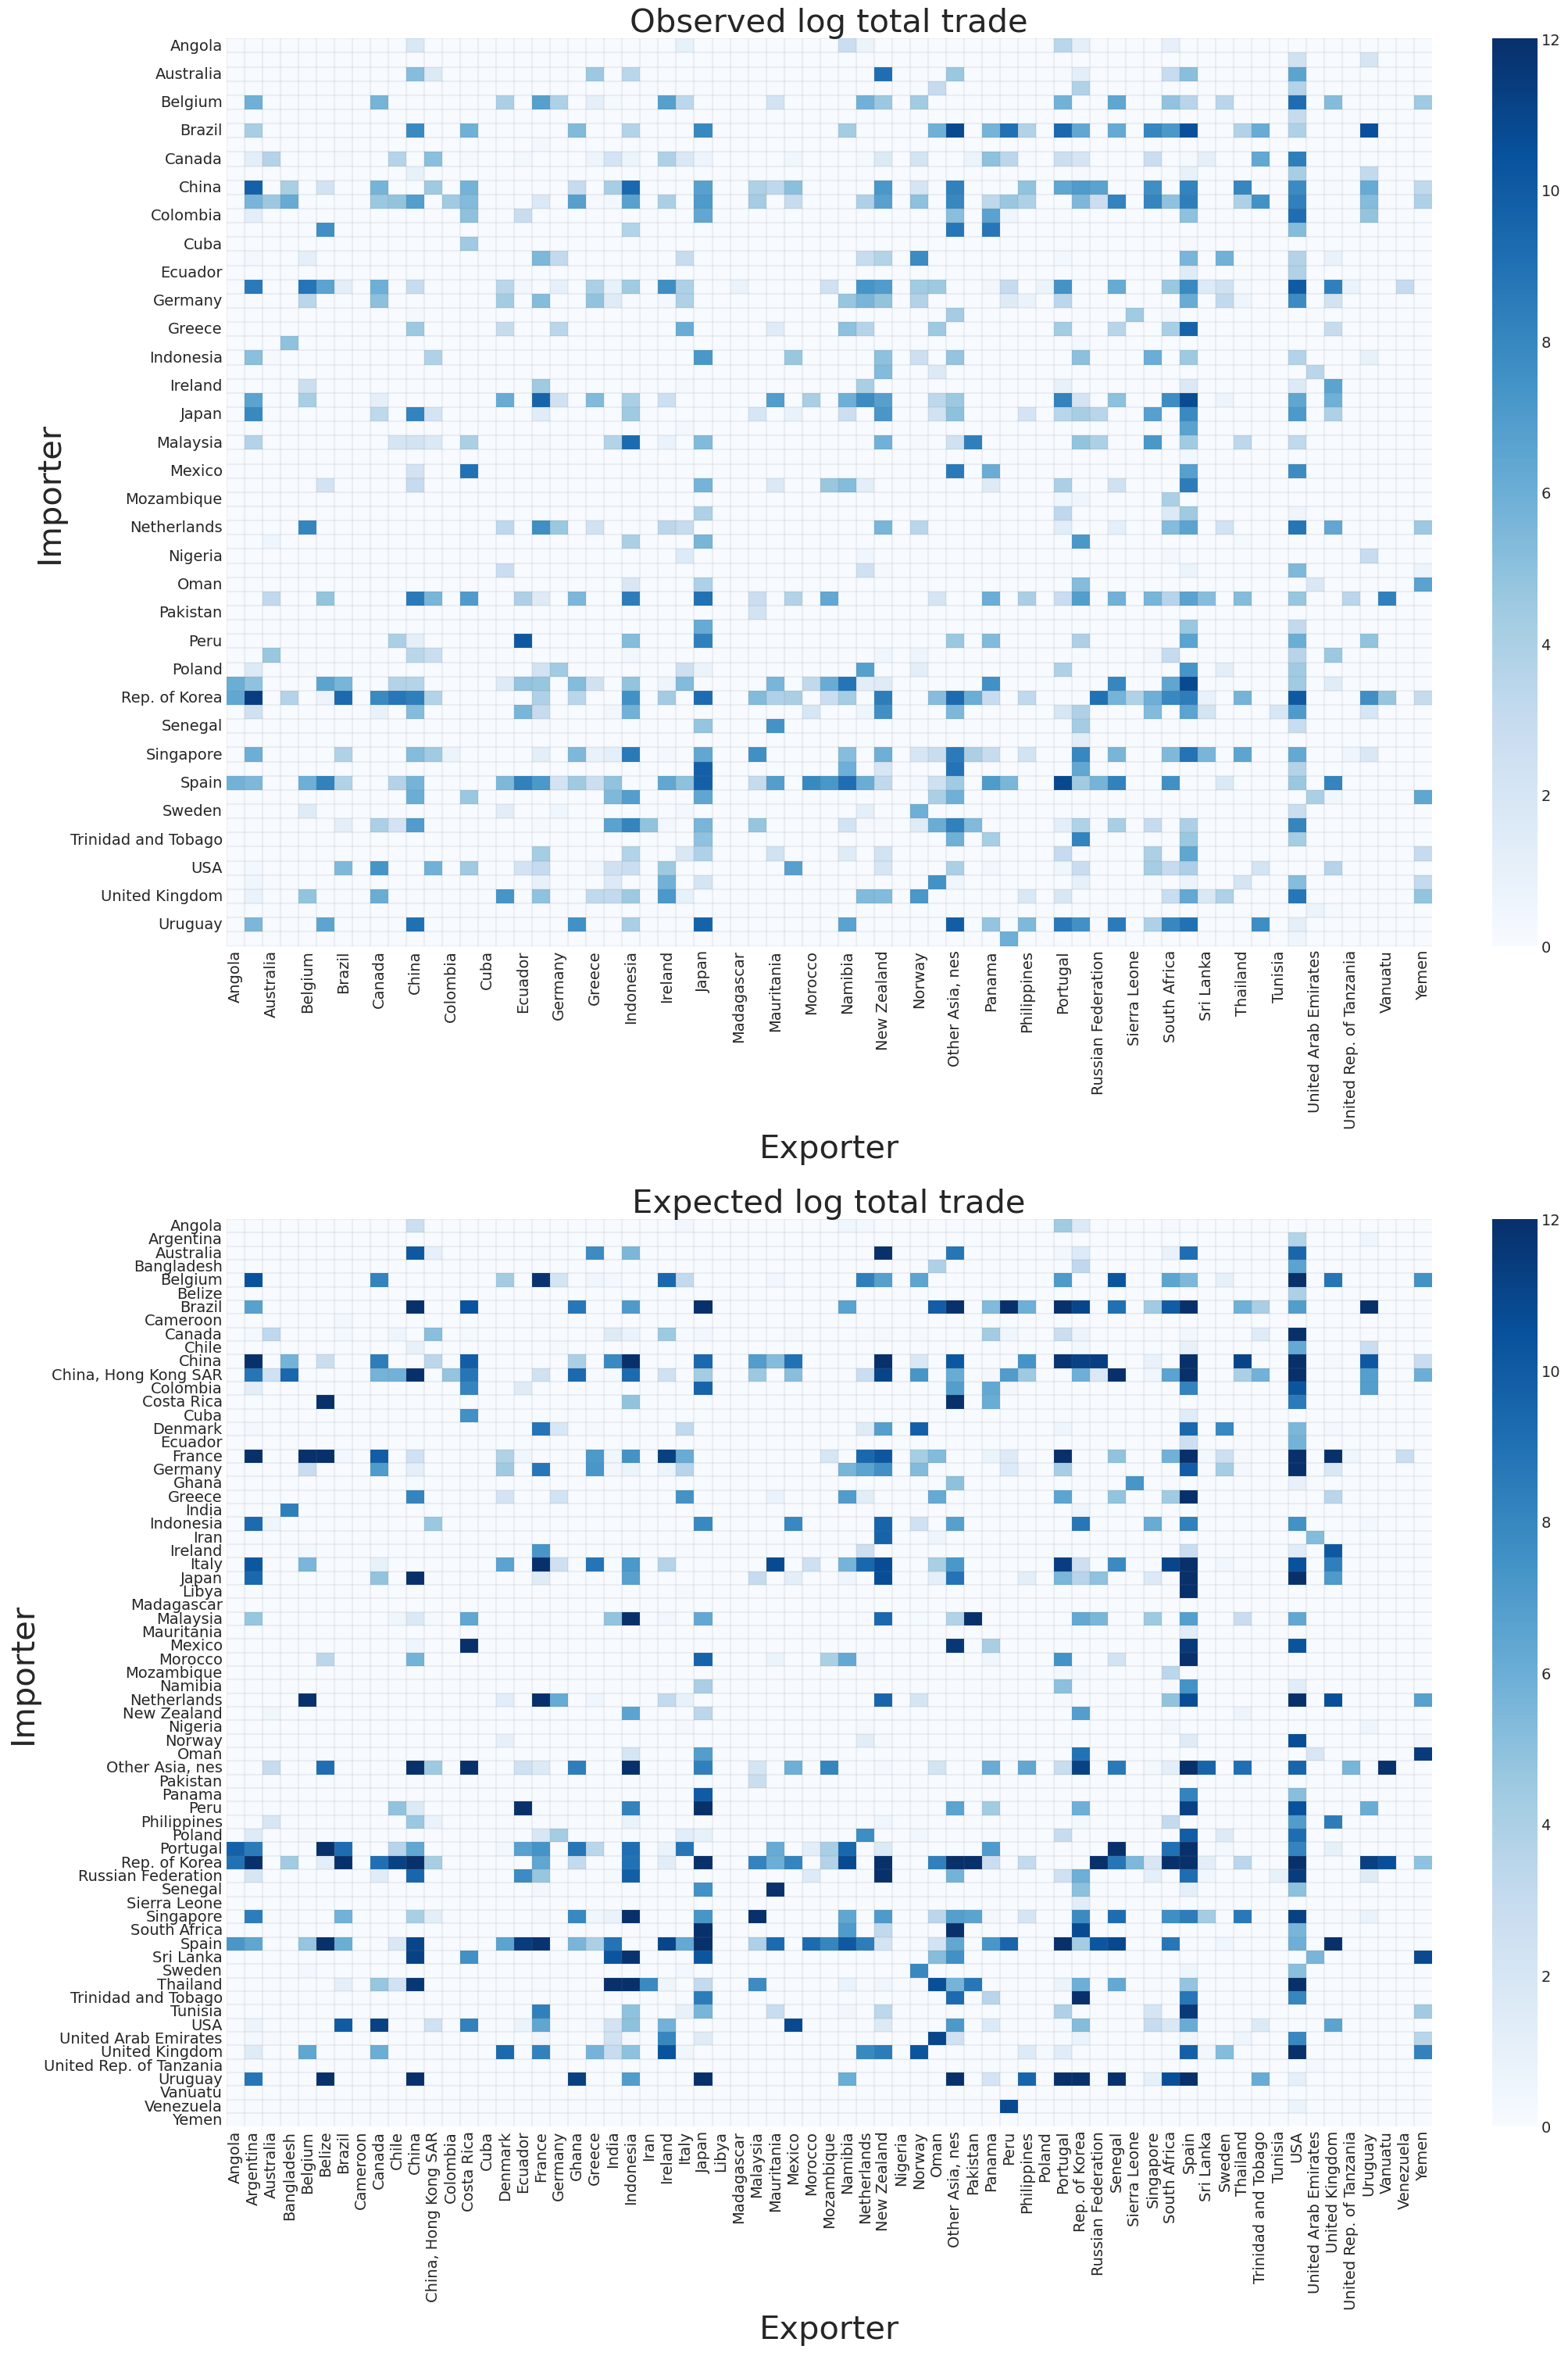

In [54]:
# Grab observed trade
tmp = (tdata[((tdata.ISOex_i).isin(biggest_countries))& ((tdata.ISOim_j).isin(biggest_countries))]
    .groupby(["ISOex_i", "ISOim_j"])
    .sum()["estimated_live_weight"]
    .reset_index())
tmp.ISOex_i = biggest_countries_long[match(tmp.ISOex_i,list(biggest_countries))]
tmp.ISOim_j = biggest_countries_long[match(tmp.ISOim_j,list(biggest_countries))] 

tdata_cut_sharks_ = (
    tmp
    .set_index("ISOex_i")
    .pivot(columns="ISOim_j")
    .droplevel(0, axis="columns")
)

# Add missing rows 
for i in tdata_cut_sharks_.columns:
    if i not in tdata_cut_sharks_.index:
        tdata_cut_sharks_ = pd.concat([pd.DataFrame(index=[i],columns=tdata_cut_sharks_.columns),tdata_cut_sharks_])

# Tidy up
tdata_cut_sharks_ = tdata_cut_sharks_.sort_index().fillna(0.0)

# Grab total expected trade
post_latent_trade = np.expm1(
    (idata_trade_x.posterior["expected_log_shark_trade"]+idata_trade_x.posterior["expected_log_ray_trade"])
    .median(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
        "Importer": ("importer", biggest_countries_long)})
        .drop_vars(['exporter','importer']))

# Set up plot
_, ax = plt.subplots(2,1,figsize=(20, 30))

# Observed
sns.heatmap(
    np.log1p(tdata_cut_sharks_).T,
    ax=ax[0],
    cmap=cmap,vmin=0, vmax=12
)
ax[0].hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax[0].vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax[0].set_title("Observed log total trade", fontsize=30)
ax[0].set_xlabel("Exporter", fontsize=30)
ax[0].set_ylabel("Importer", fontsize=30)

# Predicted
sns.heatmap(
    np.log1p(post_latent_trade.to_dataframe(name="expected_trade")
    .reset_index().drop(['exporter','importer'],axis=1)
    .set_index(['Exporter','Importer']).unstack()
    .droplevel(0, axis=1)
    .T),
    ax=ax[1],
    cmap=cmap, vmin=0, vmax=12
)

ax[1].hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax[1].vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax[1].set_title("Expected log total trade", fontsize=30)
ax[1].set_xlabel("Exporter", fontsize=30)
ax[1].set_ylabel("Importer", fontsize=30)

#plt.savefig(os.getcwd()+'/Figures/Global/'+'Observed_vs_Expected_log_trade.jpg',dpi=300);


In [140]:
txdata

logReported_taxon_landings  taxon_tax_id  country_tax_id  year_tax_id  \
0                       0.000000             5               3            0   
1                       0.000000             5               3            1   
2                       0.000000             5               3            2   
3                       0.000000             5               3            3   
4                       0.000000             5               3            4   
...                          ...           ...             ...          ...   
1327                    6.352629             4              66            1   
1328                    6.548219             4              66            2   
1329                    6.297109             4              66            3   
1330                    6.545350             4              66            4   
1331                    4.418841             4              66            5   

     country    year           taxon  
0        AUS  year_1      Etmopterus  
1        AUS  year_2      Etmopterus  
2        AUS  year_3      Etmopterus  
3        AUS  year_4      Etmopterus  
4        AUS  year_5      Etmopterus  
...      ...     ...             ...  
1327     ZAF  year_2  Elasmobranchii  
1328     ZAF  year_3  Elasmobranchii  
1329     ZAF  year_4  Elasmobranchii  
1330     ZAF  year_5  Elasmobranchii  
1331     ZAF  year_6  Elasmobranchii  

[1332 rows x 7 columns]

# Look at overall totals

## Observed bits for plotting


In [30]:
np.exp(sdata.drop(columns=['year','year_spp_id','country_spp_id','species_spp_id']
          ).groupby(['country','species']).mean())

logReported_species_landings
country species                                              
ARG     Atlantoraja castelnaui                       5.495333
        Atlantoraja cyclophora                      39.603196
        Bathyraja brachyurops                        9.552975
        Bathyraja macloviana                         1.709976
        Carcharhinus brachyurus                      2.492883
...                                                       ...
ZAF     Galeorhinus galeus                         165.177248
        Isurus oxyrinchus                          673.621869
        Mustelus mustelus                          129.937946
        Notorynchus cepedianus                       3.525469
        Prionace glauca                            441.536459

[457 rows x 1 columns]

In [23]:
# Grab species level estimates for observed data
Obs_spp_data = np.exp(sdata.drop(columns=['year','year_spp_id','country_spp_id','species_spp_id']
          ).groupby(['country','species']).mean()).rename(columns={"logReported_species_landings": "Reported_landings"})

# Create xarray data of totals by species
Obs_spp_sums = xr.Dataset(Obs_spp_data.groupby(level='species').sum().sort_values(by='Reported_landings', ascending=False))

# Grab taxon level estimates for observed data
Obs_tax_data = np.exp(txdata.drop(columns=['year','year_tax_id','country_tax_id','taxon_tax_id']
          ).groupby(['country','taxon']).mean()).rename(columns={"logReported_taxon_landings": "Reported_landings"})

# Net estimated unreported species-level landings
Net_spp_landings = idata_trade_x.posterior['latent_species_landings']-idata_trade_x.posterior['CountrySPP_landings']

In [24]:
Obs_spp_data

Reported_landings
country species                                   
ARG     Atlantoraja castelnaui            5.495333
        Atlantoraja cyclophora           39.603196
        Bathyraja brachyurops             9.552975
        Bathyraja macloviana              1.709976
        Carcharhinus brachyurus           2.492883
...                                            ...
ZAF     Galeorhinus galeus              165.177248
        Isurus oxyrinchus               673.621869
        Mustelus mustelus               129.937946
        Notorynchus cepedianus            3.525469
        Prionace glauca                 441.536459

[457 rows x 1 columns]

In [25]:
# Look at top 10 reported landings by species
Obs_spp_data.groupby(level='species').sum().sort_values(by='Reported_landings', ascending=False).head(10)

Reported_landings
species                                    
Prionace glauca               137118.688452
Squalus acanthias              16115.943154
Isurus oxyrinchus              11917.878196
Scyliorhinus canicula           6794.932796
Leucoraja ocellata              6240.693511
Raja clavata                    5136.668585
Carcharhinus falciformis        4612.035467
Leucoraja erinacea              4564.284300
Mustelus schmitti               4329.136535
Galeorhinus galeus              4168.742682

## Plot top reported and unreported species

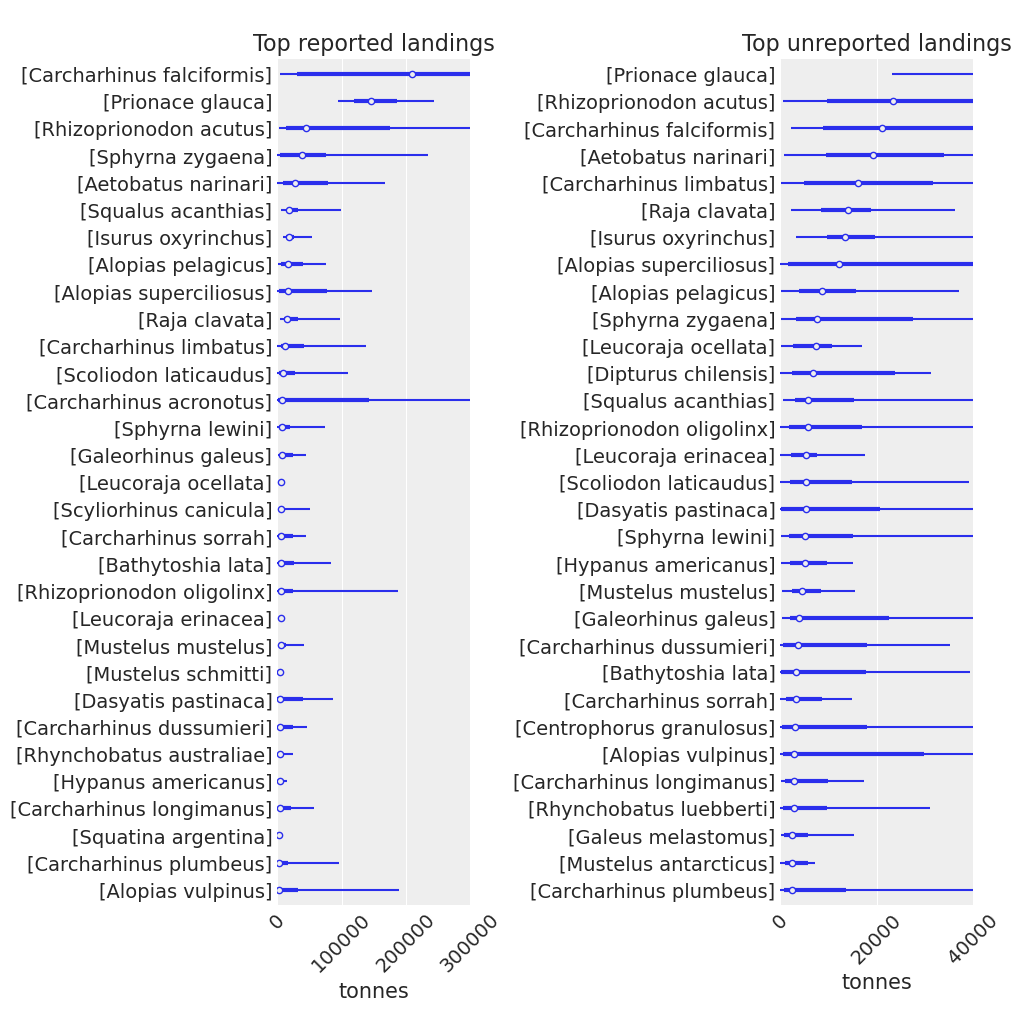

In [26]:
# = = = = = Set up plot
_, ax = plt.subplots(1,2,figsize=(10, 10))

# Select top 10% of landed species
tmp = idata_trade_x.posterior['CountrySPP_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

# Select top 10% of unreported species
tmp = Net_spp_landings.sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_unrep = tmp[tmp>np.quantile(tmp,0.90)].species

# = = = = = Plot reported species landings
az.plot_forest(idata_trade_x.posterior['CountrySPP_landings'].sum(('exporter')).sel(species=sppx_landed).rename(''),
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               ax=ax[0]
                   )
ax[0].set(
    title="Top reported landings",
    xlabel="tonnes",
    ylabel="",
);
ax[0].set_xlim(0,300000)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

# = = = = = Plot unreported species landings
az.plot_forest(Net_spp_landings.sum(('exporter')).sel(species=sppx_unrep).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                    hdi_prob=0.9,
                   ax=ax[1]
                   )
ax[1].set(
    title="Top unreported landings",
    xlabel="tonnes",
    ylabel="",
)
ax[1].set_xlim(0,40000)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

#plt.savefig(os.getcwd()+'/Figures/Global/'+'Reported_Unreported_species.jpg',dpi=300);

# Plot latent species

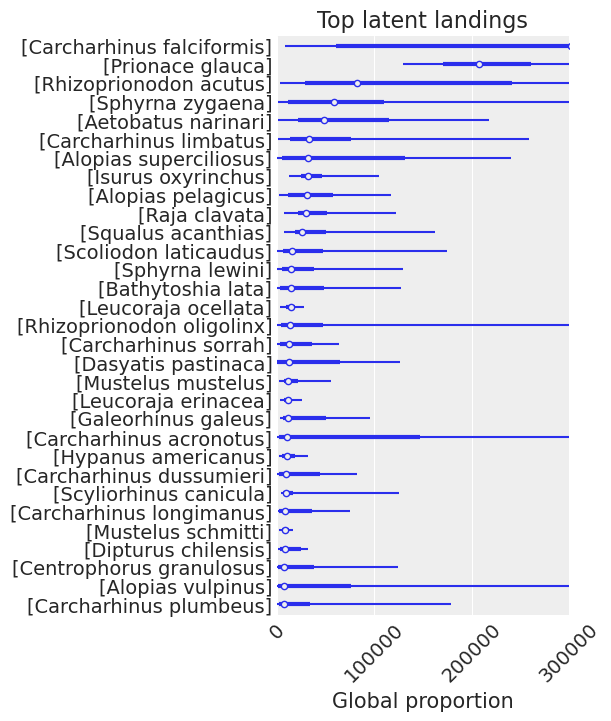

In [27]:
# Select top 10% of landed species
tmp = idata_trade_x.posterior['latent_species_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['latent_species_landings'].sum(('exporter')).sel(species=sppx_landed).rename('')
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title="Top latent landings",
    xlabel="Global proportion",
    ylabel="",
);
ax[0].set_xlim(0,300000)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
plt.savefig('Latent_species_landings.jpg',dpi=300);

In [28]:
# Select top 10% of traded species
tmp = idata_trade_x.posterior['amount_exported'].sum(('exporter','importer')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

In [29]:
sppx_landed

<xarray.DataArray 'species' (species: 31)>
array(['Carcharhinus falciformis', 'Prionace glauca', 'Rhizoprionodon acutus',
       'Sphyrna zygaena', 'Aetobatus narinari', 'Carcharhinus limbatus',
       'Alopias superciliosus', 'Isurus oxyrinchus', 'Alopias pelagicus',
       'Raja clavata', 'Squalus acanthias', 'Scoliodon laticaudus',
       'Sphyrna lewini', 'Bathytoshia lata', 'Leucoraja ocellata',
       'Rhizoprionodon oligolinx', 'Carcharhinus sorrah', 'Dasyatis pastinaca',
       'Mustelus mustelus', 'Leucoraja erinacea', 'Galeorhinus galeus',
       'Carcharhinus acronotus', 'Hypanus americanus',
       'Carcharhinus dussumieri', 'Scyliorhinus canicula',
       'Carcharhinus longimanus', 'Mustelus schmitti', 'Dipturus chilensis',
       'Centrophorus granulosus', 'Alopias vulpinus', 'Carcharhinus plumbeus'],
      dtype='<U29')
Coordinates:
  * species  (species) <U29 'Carcharhinus falciformis' ... 'Carcharhinus plum...

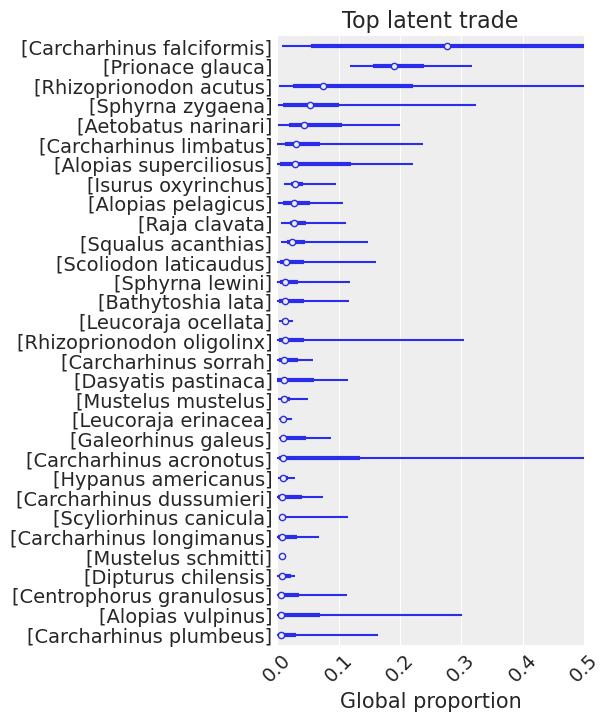

In [30]:
# = = = = = Plot latent traded landings
tmp = idata_trade_x.posterior['amount_exported'].sum(('exporter','importer')).sel(species=sppx_landed).rename('')
ax = az.plot_forest(tmp/tmp.median(('chain','draw')).sum(),
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title="Top latent trade",
    xlabel="Global proportion",
    ylabel="",
);
ax[0].set_xlim(0,0.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
plt.savefig('Latent_species_proportions.jpg',dpi=300);

In [31]:
Obs_spp_data

Reported_landings
country species                                   
ARG     Atlantoraja castelnaui            5.495333
        Atlantoraja cyclophora           39.603196
        Bathyraja brachyurops             9.552975
        Bathyraja macloviana              1.709976
        Carcharhinus brachyurus           2.492883
...                                            ...
ZAF     Galeorhinus galeus              165.177248
        Isurus oxyrinchus               673.621869
        Mustelus mustelus               129.937946
        Notorynchus cepedianus            3.525469
        Prionace glauca                 441.536459

[457 rows x 1 columns]

In [32]:
Obs_spp_data[Obs_spp_data.Reported_landings>5]

Reported_landings
country species                                   
ARG     Atlantoraja castelnaui            5.495333
        Atlantoraja cyclophora           39.603196
        Bathyraja brachyurops             9.552975
        Dipturus chilensis              513.256905
        Galeorhinus galeus               49.456186
...                                            ...
ZAF     Carcharhinus brachyurus          41.800013
        Galeorhinus galeus              165.177248
        Isurus oxyrinchus               673.621869
        Mustelus mustelus               129.937946
        Prionace glauca                 441.536459

[265 rows x 1 columns]

## Loop for selected country results

In [133]:
# Countries to loop over
cnames = ['ESP','CHN', 'CAN', 'BLZ', 'IND', 'IDN', 'TWN', 'JPN', 'USA']

# Plotting loop
for counx in cnames:
    try:
        # Grab long country name
        couny = biggest_countries_long[list(biggest_countries).index(counx)]
        
        # Select species estimated to have more than 5 t of landings
        tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
        tmp = tmp.sortby(tmp, ascending=False)
        sppxxx = tmp[tmp>5].species.to_numpy()
    
        # Plot latent landings >5 t
        ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                            #transform=np.log1p,
                            figsize=(10,6)
                           )
        ax[0].set(
            title="Average latent species landings "+couny,
            xlabel="tonnes",
            ylabel="",
        )
        #ax[0].set_xlim(0,6000)
        plt.tight_layout()
        plt.savefig(bf+'/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300)
        plt.close()
    
    
        # Plot observed vs predicted species landings
        # List of top latent plus observed species >5t
        xtmp = Obs_spp_data.loc[counx][Obs_spp_data.loc[counx].Reported_landings>5].reset_index()
        sppzzz = list(sppxxx)+[x for x in xtmp.species if x not in sppxxx]
        
        ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz),
                            idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz)],
                            model_names=["Prior", "Posterior"],
                            transform=np.log1p,
                            figsize=(10, 6)
                           )
        
        
        # Add observed average landings reported to species
        rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz).mean(("chain", "draw")).species.to_numpy())
        ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
        plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)
        
        ax[0].set(
            title="Average reported species landings "+couny,
            xlabel="log(tonnes)",
            ylabel="",
        )
        plt.savefig(bf+'/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300)
        plt.close()
    except:
        plt.close()
        print('No species data for '+counx)
    

    try:
        ## Plot taxon level estimates
        # Select only taxa estimated to have some landings
        taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]
        # List of top latent plus observed taxa
        taxzzz = list(taxxx)+[x for x in Obs_tax_data.loc[counx].index if x not in taxxx]
        
        
        ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxzzz).rename(''),
                            idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxzzz).rename('')],
                            model_names=["Prior", "Posterior"],
                            transform=np.log1p,
                            #figsize=(10, 20)
                           )
        
        # Add observed average landings reported to species
        xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
        rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxzzz).taxon.to_numpy())
        ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
        # Plot observed aggregations
        plt.scatter(xtmp,ytmp,c='black',zorder=10)
        
        ax[0].set(
            title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
            xlabel="log(tonnes)",
            ylabel="",
        )
        plt.savefig(bf+'/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300)
        plt.close()
    
    
        # Plot taxon aggegration proportions by species
        PostTaxonSpp = (
                idata_trade_x.posterior["CountryTaxon_SPP_landings"]
                .median(("chain", "draw"))
                .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
                .sel(exporter=counx)
                .drop_vars(['exporter'])
            ).to_dataframe()
        PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]
        
        # Posterior species landings
        PostSpp = (
                idata_trade_x.posterior["CountrySPP_landings"]
                .median(("chain", "draw"))
                .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
                .sel(exporter=counx)
                .drop_vars(['exporter'])-1
            ).to_dataframe()
        PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]
        
        
        # Remove species not present
        #zindx = post_species_land>0
    
        if PostTaxonSpp.shape[0]==0:
            plt.close()
        else:
            # One liner to create a stacked bar chart.
            ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
                         multiple='stack', palette='tab20c', shrink=0.8)
            ax.set_ylabel('Landings (t)')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
            # Fix the legend so it's not on top of the bars.
            legend = ax.get_legend()
            legend.set_bbox_to_anchor((1, 1))
            plt.savefig(bf+'/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300)
            plt.close()
    except:
        plt.close()
        print('No taxon data for '+counx)

print('Done plotting!')
    #"""




    


    

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=

No taxon data for BLZ


/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


No species data for IND


/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed numbe

Done plotting!


/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1793185931.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


## look at Spain

In [62]:
counx = 'ESP'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

In [63]:
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
tmp[tmp>100].species.to_numpy()

array(['Prionace glauca', 'Isurus oxyrinchus', 'Raja clavata',
       'Leucoraja naevus', 'Scyliorhinus canicula', 'Dalatias licha',
       'Scyliorhinus stellaris', 'Raja montagui', 'Galeus melastomus',
       'Squalus blainville', 'Galeorhinus galeus'], dtype='<U29')

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/3789123378.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


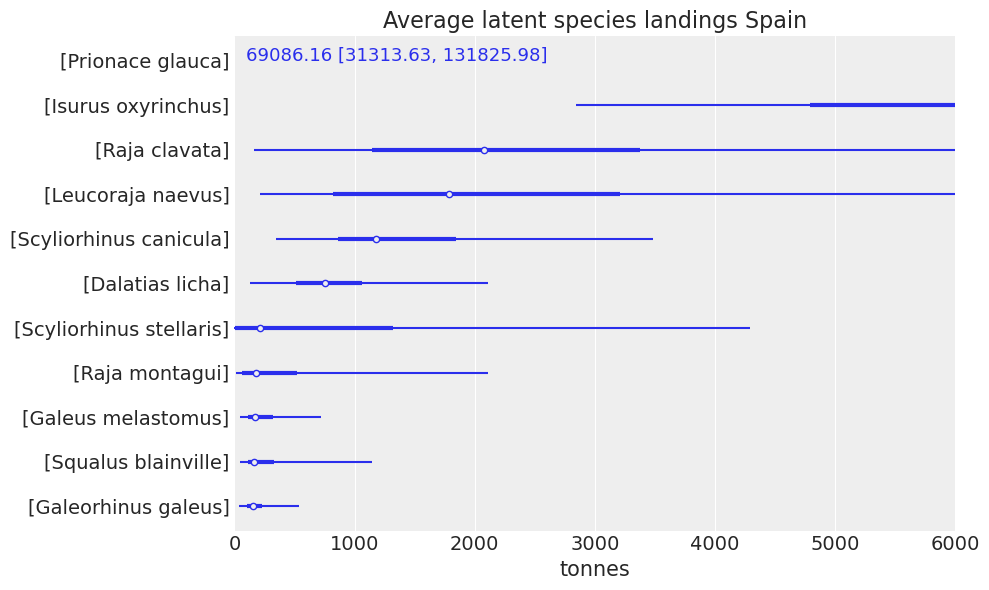

In [64]:
# Grab blue shark numbers
bs_quants = idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, 
                        species="Prionace glauca").quantile((0.5,0.05,0.95)).round(2).to_numpy()

# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>100].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
ax[0].set_xlim(0,6000)
ax[0].text(x=100,y=ax[0].get_yticks()[-1],s=str(bs_quants[0])+" ["+str(bs_quants[1])+", "+str(bs_quants[2])+"]", fontsize=13, c='C0')
plt.tight_layout()
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [65]:
Obs_spp_data.loc[counx]

Reported_landings
species                                    
Amblyraja georgiana                1.000000
Bathyraja eatonii                  1.000000
Bathytoshia centroura              1.200937
Carcharhinus falciformis           1.587401
Centrophorus granulosus            9.418936
Dalatias licha                   443.923416
Deania profundorum                 6.236918
Dipturus oxyrinchus               52.598709
Etmopterus spinax                  3.872983
Galeorhinus galeus                94.117429
Galeus melastomus                100.556254
Gymnura altavela                   1.414214
Isurus oxyrinchus               5192.004276
Isurus paucus                     22.550584
Lamna nasus                        1.973068
Leucoraja circularis               9.303967
Leucoraja fullonica               23.690327
Leucoraja naevus                 433.785499
Mobula mobular                     1.122462
Mustelus mustelus                 21.572156
Prionace glauca                65423.834089
Raja asterias                     21.801733
Raja brachyura                     4.594620
Raja clavata                     524.818636
Raja microocellata                 1.955981
Raja miraletus                     6.089927
Raja montagui                     41.379592
Raja undulata                      5.004417
Rhinobatos rhinobatos              2.092730
Rostroraja alba                    1.122462
Scyliorhinus canicula            683.660477
Scymnodon ringens                  1.122462
Squalus acanthias                 12.308285
Squalus blainville                68.065133
Squatina squatina                  3.525469

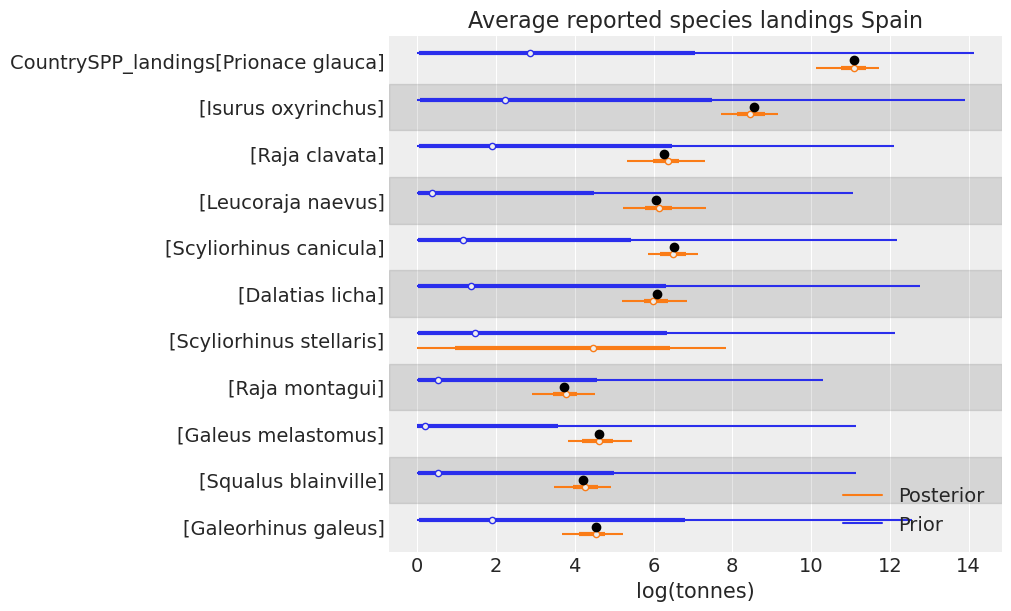

In [66]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].mean(("chain", "draw")).sel(exporter=counx, species=sppxxx).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].loc[np.array([x for x in rowlist if x in Obs_spp_data.loc[counx].index])].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(couny+'_Reported_species_landings.jpg',dpi=300);

In [68]:
rowlist

['Prionace glauca',
 'Isurus oxyrinchus',
 'Raja clavata',
 'Leucoraja naevus',
 'Scyliorhinus canicula',
 'Dalatias licha',
 'Scyliorhinus stellaris',
 'Raja montagui',
 'Galeus melastomus',
 'Squalus blainville',
 'Galeorhinus galeus']

species  Reported_landings
4   Centrophorus granulosus           9.418936
5            Dalatias licha         443.923416
6        Deania profundorum           6.236918
7       Dipturus oxyrinchus          52.598709
9        Galeorhinus galeus          94.117429
10        Galeus melastomus         100.556254
12        Isurus oxyrinchus        5192.004276
13            Isurus paucus          22.550584
15     Leucoraja circularis           9.303967
16      Leucoraja fullonica          23.690327
17         Leucoraja naevus         433.785499
19        Mustelus mustelus          21.572156
20          Prionace glauca       65423.834089
21            Raja asterias          21.801733
23             Raja clavata         524.818636
25           Raja miraletus           6.089927
26            Raja montagui          41.379592
27            Raja undulata           5.004417
30    Scyliorhinus canicula         683.660477
32        Squalus acanthias          12.308285
33       Squalus blainville          68.065133

[Text(0.5, 1.0, 'Average reported species landings Spain'),
 Text(0.5, 0, 'log(tonnes)'),
 Text(0, 0.5, '')]

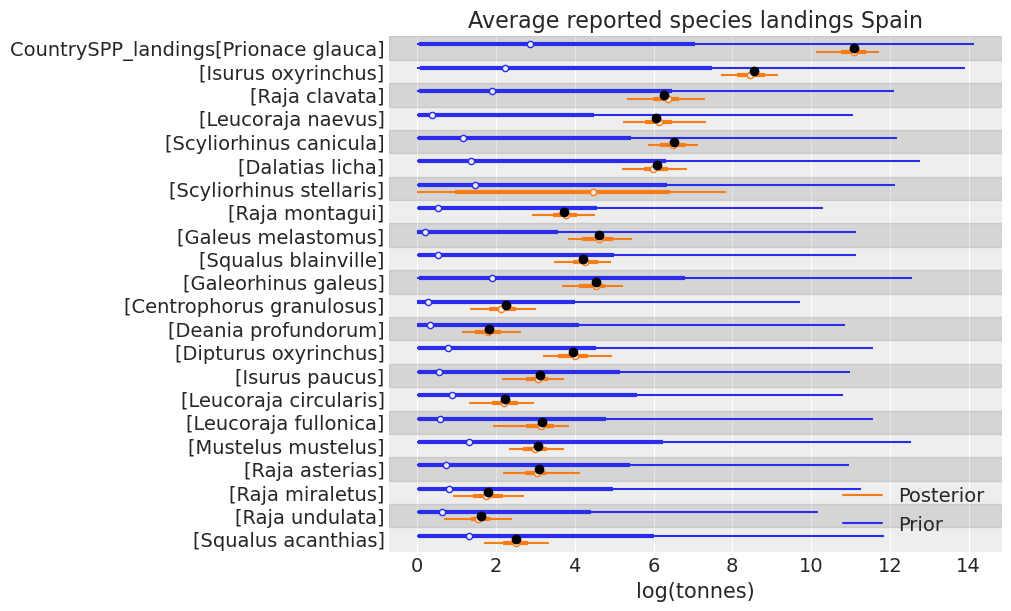

In [84]:
# List of top latent plus observed species >5t
sppzzz = list(sppxxx)+[x for x in xtmp[xtmp.Reported_landings>5].species if x not in sppxxx]

ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppzzz).mean(("chain", "draw")).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].loc[xtmp[xtmp.Reported_landings>5].species].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
);

In [87]:

"""
#ax = az.plot_forest(idata_trade_x.posterior['PsppIdent'].sel(exporter=counx, species=sppxxx).rename(''),
ax = az.plot_forest(idata_trade_x.posterior['PsppIdent'].sel(exporter=counx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,40)
                   )
ax[0].set(
    title="Expected proportion reported to species "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="",
    ylabel="",
)

plt.tight_layout();
#"""

'\n#ax = az.plot_forest(idata_trade_x.posterior[\'PsppIdent\'].sel(exporter=counx, species=sppxxx).rename(\'\'),\nax = az.plot_forest(idata_trade_x.posterior[\'PsppIdent\'].sel(exporter=counx).rename(\'\'),\n                    #transform=np.log1p,\n                    figsize=(10,40)\n                   )\nax[0].set(\n    title="Expected proportion reported to species "+biggest_countries_long[list(biggest_countries).index(counx)],\n    xlabel="",\n    ylabel="",\n)\n\nplt.tight_layout();\n#'

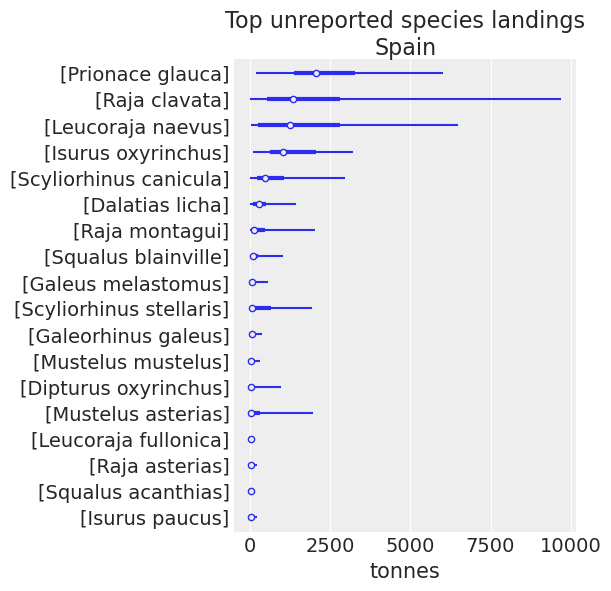

In [47]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(couny+'_Unreported_landings.jpg',dpi=300);

In [88]:
xtmp

array([2.21367171, 1.77423748, 5.50732173, 0.32431836, 4.22801427,
       2.94405075, 8.20724031, 8.13761232, 6.14041353, 4.60559436,
       5.27035876, 4.04729824])

In [91]:
Obs_tax_data.loc[counx].index

Index(['Carcharhinidae', 'Dasyatidae', 'Elasmobranchii', 'Etmopterus',
       'Mustelus', 'Myliobatidae', 'Rajidae', 'Rajiformes', 'Scyliorhinidae',
       'Scyliorhinus', 'Selachimorpha', 'Squalidae'],
      dtype='object', name='taxon')

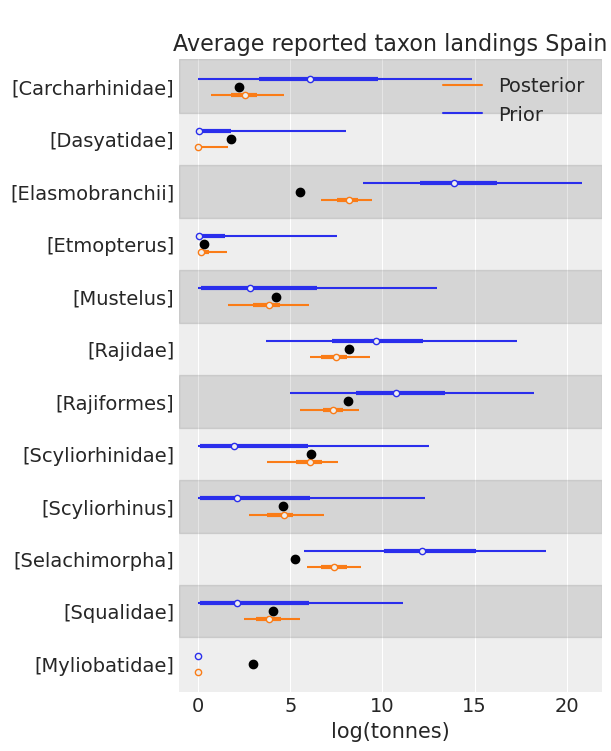

In [92]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]
# List of top latent plus observed taxa
taxzzz = list(taxxx)+[x for x in Obs_tax_data.loc[counx].index if x not in taxxx]


ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxzzz).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxzzz).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxzzz).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_69850/1299369271.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


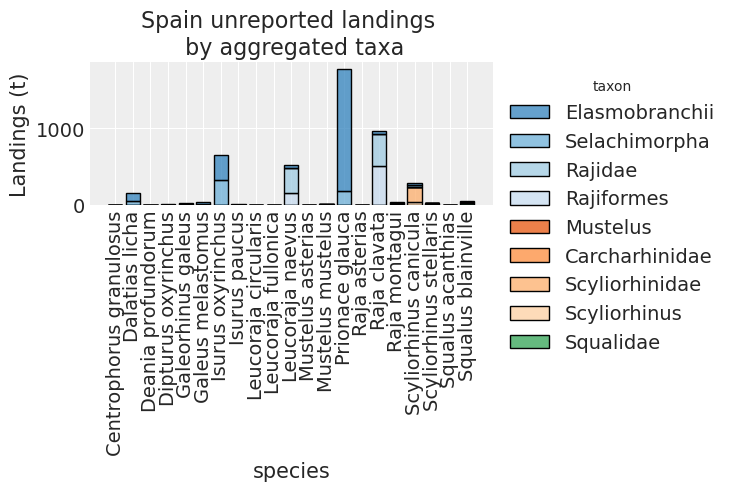

In [49]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(couny+'_Species_taxon_landings.jpg',dpi=300);

## look at Canada

In [91]:
counx = 'CAN'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_77639/592125998.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


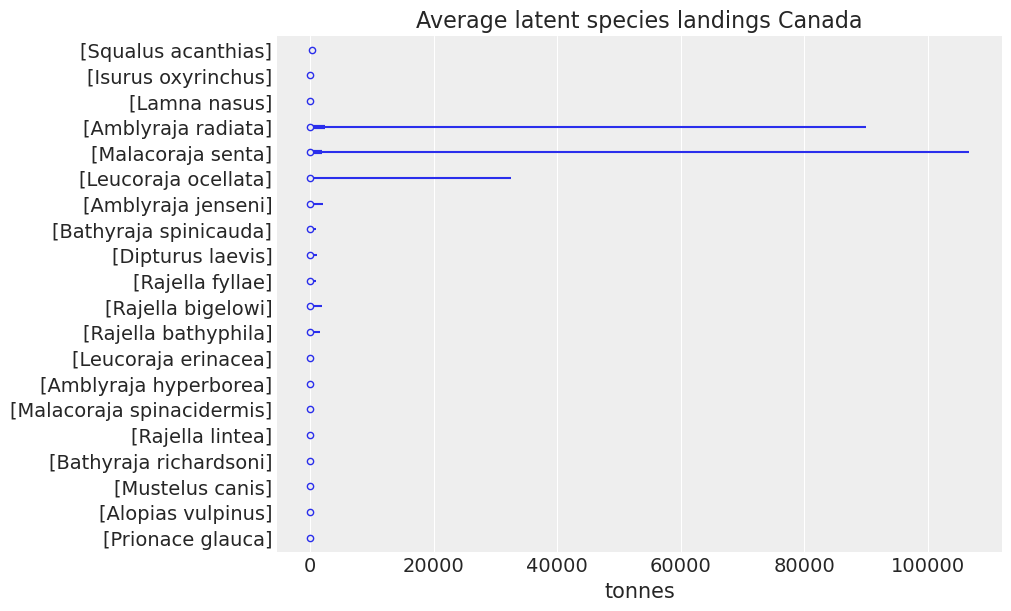

In [92]:
# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>0].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
plt.tight_layout()
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [104]:
sppxxx

array(['Squalus acanthias', 'Isurus oxyrinchus', 'Leucoraja ocellata',
       'Lamna nasus', 'Leucoraja erinacea', 'Amblyraja jenseni',
       'Rajella fyllae', 'Rajella lintea', 'Rajella bigelowi',
       'Malacoraja senta', 'Amblyraja hyperborea', 'Amblyraja radiata',
       'Dipturus laevis', 'Rajella bathyphila',
       'Malacoraja spinacidermis', 'Bathyraja spinicauda',
       'Bathyraja richardsoni', 'Alopias vulpinus', 'Mustelus canis',
       'Prionace glauca'], dtype=object)

In [105]:
Obs_spp_data.loc[counx]

Reported_landings
species                             
Isurus oxyrinchus          59.046416
Lamna nasus                 8.340377
Prionace glauca             1.259921
Squalus acanthias         341.944764

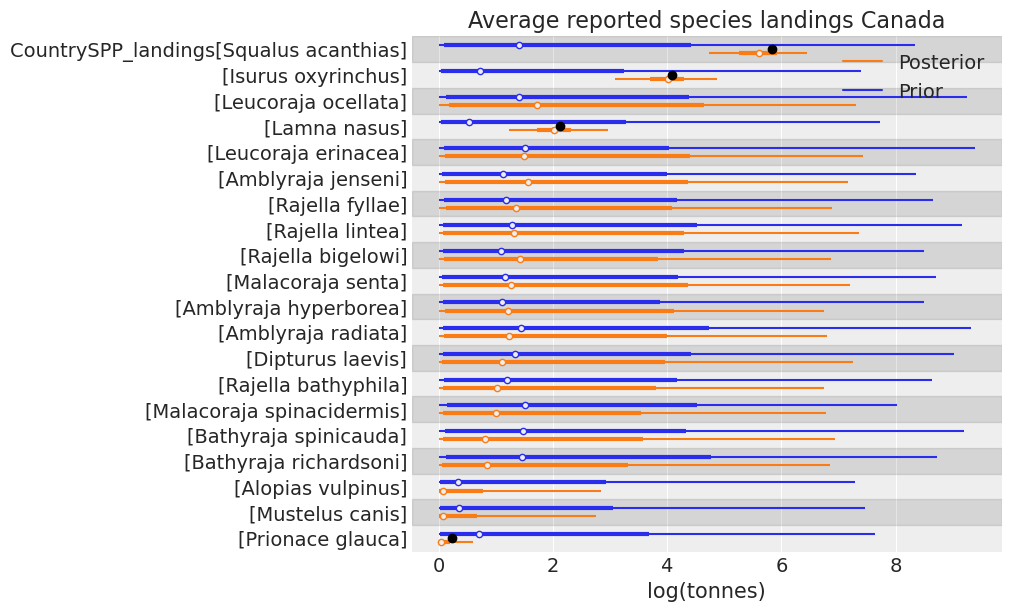

In [106]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).mean(("chain", "draw")).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

In [107]:

"""
#ax = az.plot_forest(idata_trade_x.posterior['PsppIdent'].sel(exporter=counx, species=sppxxx).rename(''),
ax = az.plot_forest(idata_trade_x.posterior['PsppIdent'].sel(exporter=counx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,40)
                   )
ax[0].set(
    title="Expected proportion reported to species "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="",
    ylabel="",
)

plt.tight_layout();
#"""

'\n#ax = az.plot_forest(idata_trade_x.posterior[\'PsppIdent\'].sel(exporter=counx, species=sppxxx).rename(\'\'),\nax = az.plot_forest(idata_trade_x.posterior[\'PsppIdent\'].sel(exporter=counx).rename(\'\'),\n                    #transform=np.log1p,\n                    figsize=(10,40)\n                   )\nax[0].set(\n    title="Expected proportion reported to species "+biggest_countries_long[list(biggest_countries).index(counx)],\n    xlabel="",\n    ylabel="",\n)\n\nplt.tight_layout();\n#'

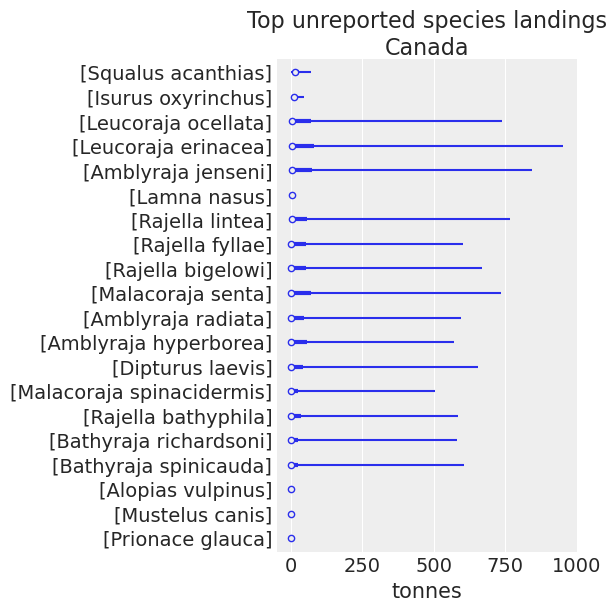

In [108]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>0].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

[Text(0.5, 1.0, 'Average reported taxon landings Canada'),
 Text(0.5, 0, 'log(tonnes)'),
 Text(0, 0.5, '')]

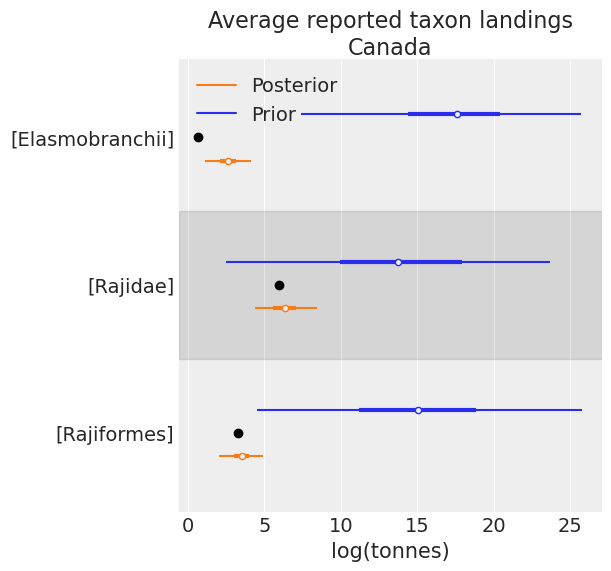

In [93]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_77639/894604280.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


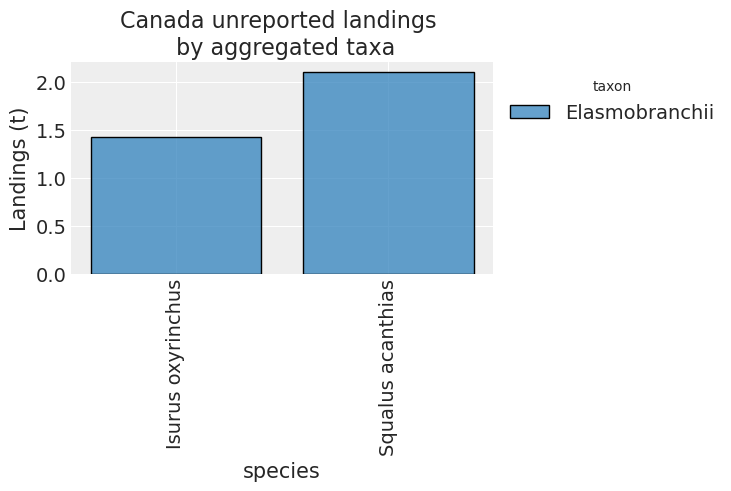

In [94]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
try:
    legend.set_bbox_to_anchor((1, 1))
except:
    pass
#plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

## look at USA

In [111]:
counx = 'USA'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/3642977823.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


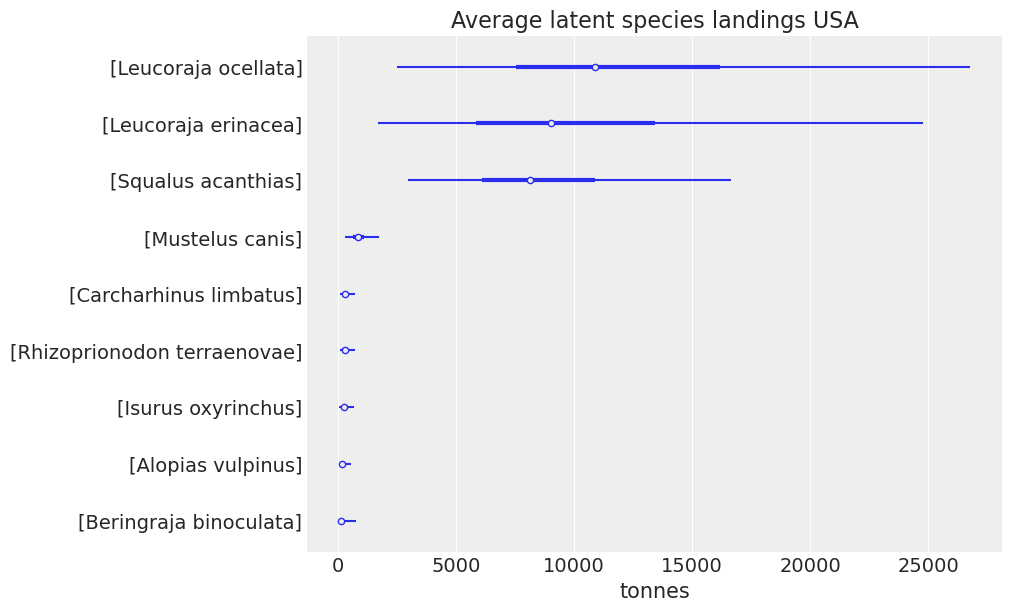

In [112]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>100].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

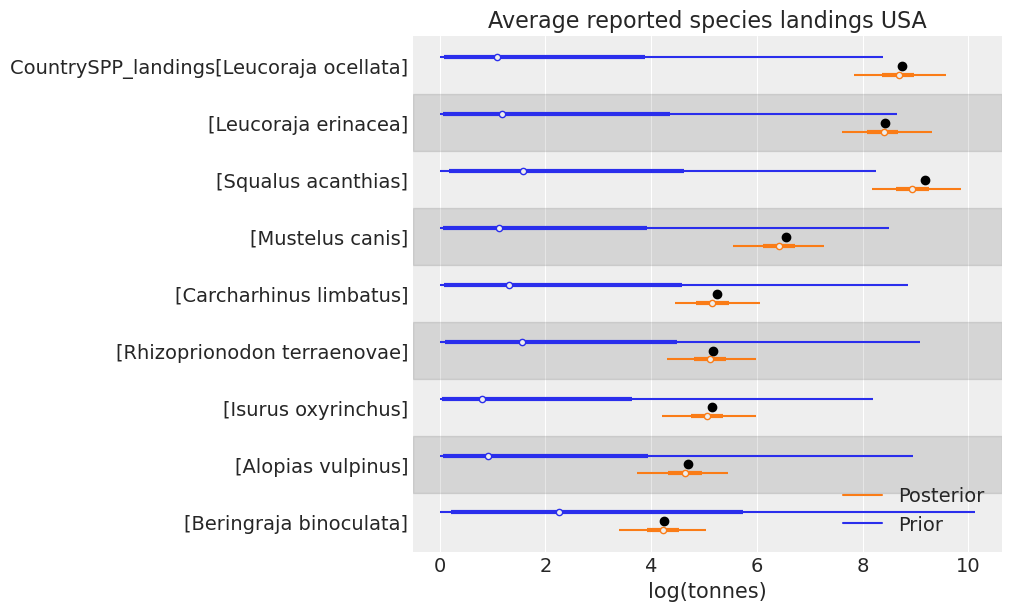

In [113]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].mean(("chain", "draw")).sel(exporter=counx, species=sppxxx).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].loc[rowlist].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

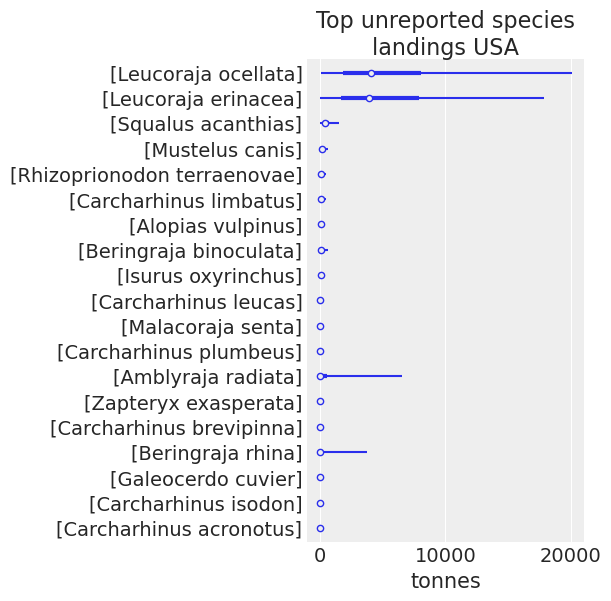

In [114]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

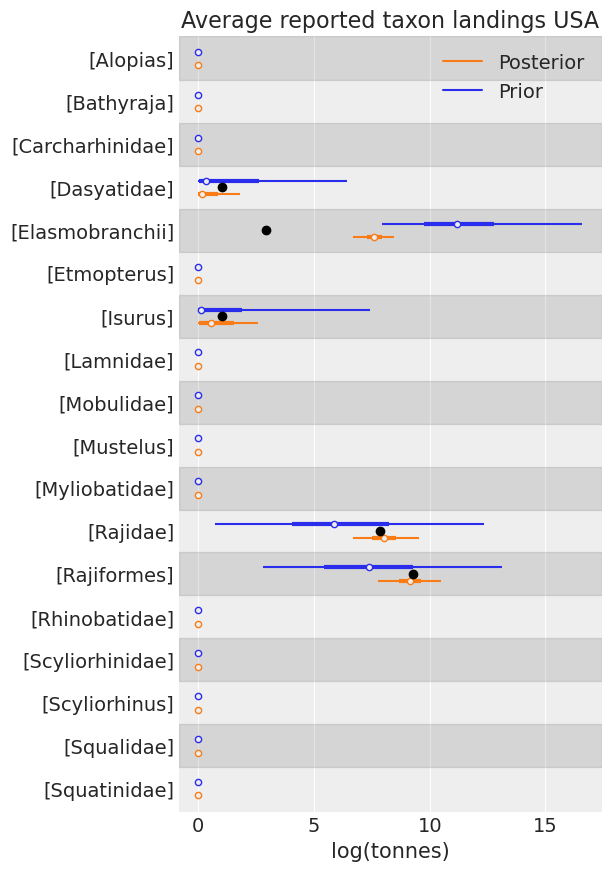

In [115]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/2935711675.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


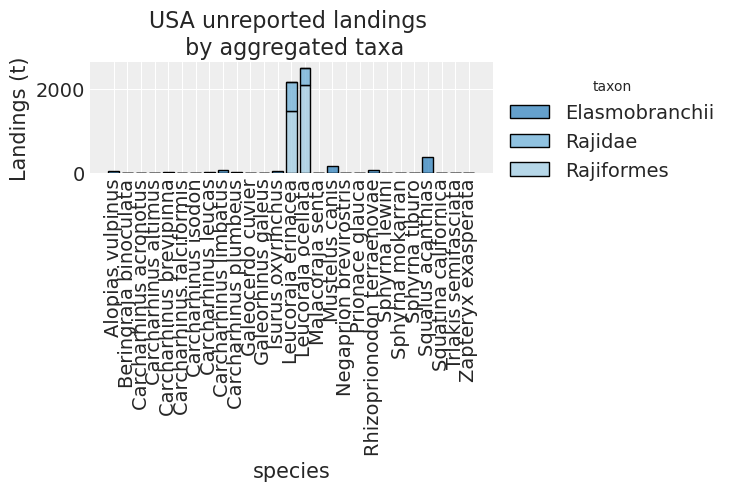

In [117]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

## look at China

In [118]:
counx = 'CHN'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/2350920403.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


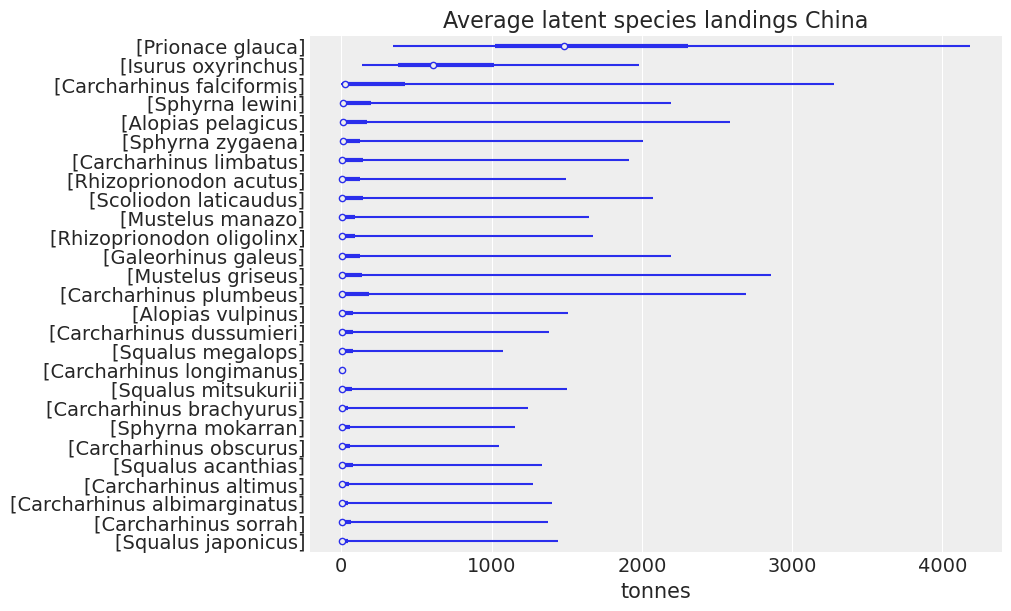

In [119]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>2].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [120]:
Obs_tax_data.loc[counx].Reported_landings

taxon
Rajiformes    4.384059
Name: Reported_landings, dtype: float64

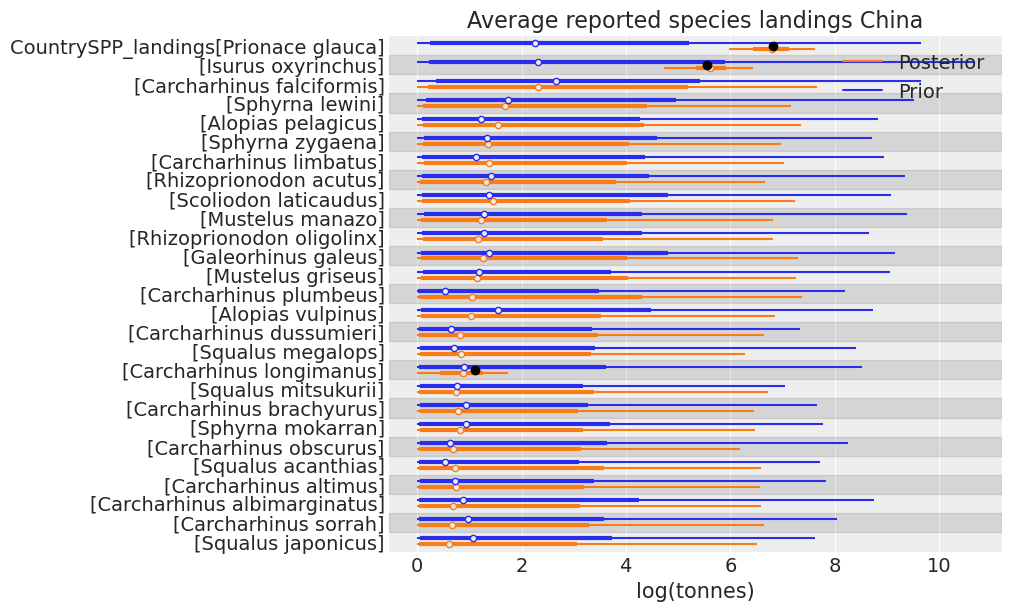

In [121]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).mean(("chain", "draw")).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

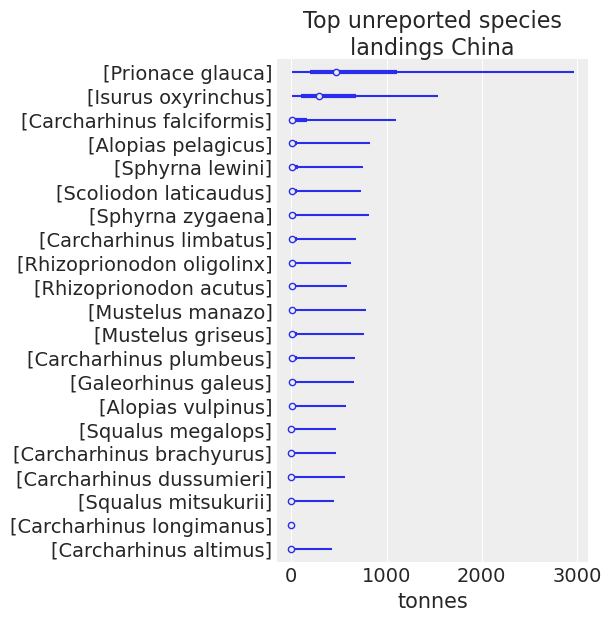

In [122]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>1].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

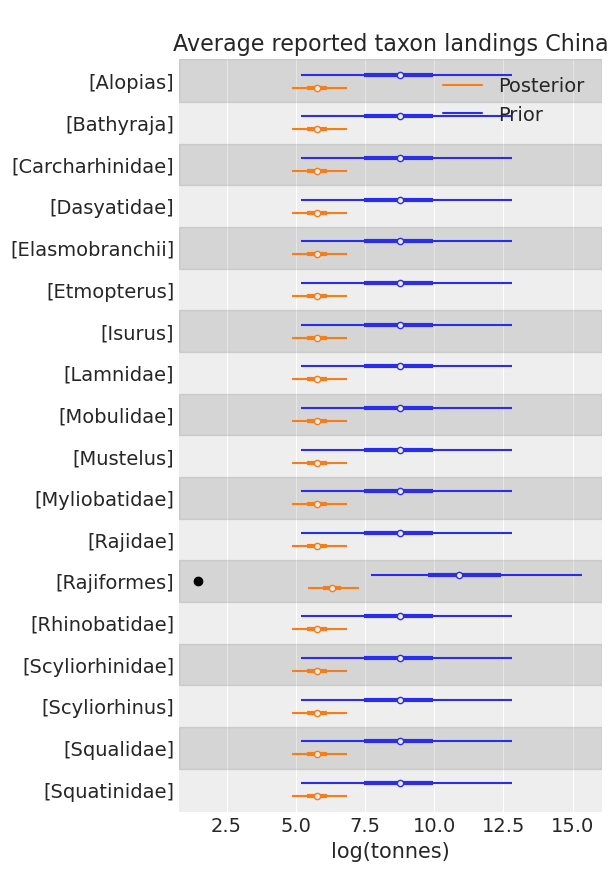

In [123]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/3908225025.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/3908225025.py:37: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);
/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


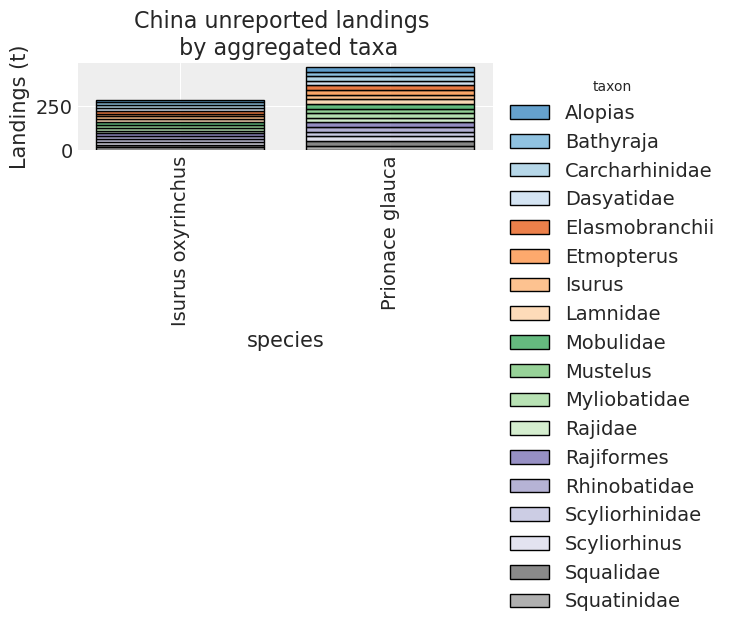

In [124]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
try:
    legend.set_bbox_to_anchor((1, 1))
except:
    pass
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

## look at Taiwan

In [125]:
counx = 'TWN'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/695665550.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


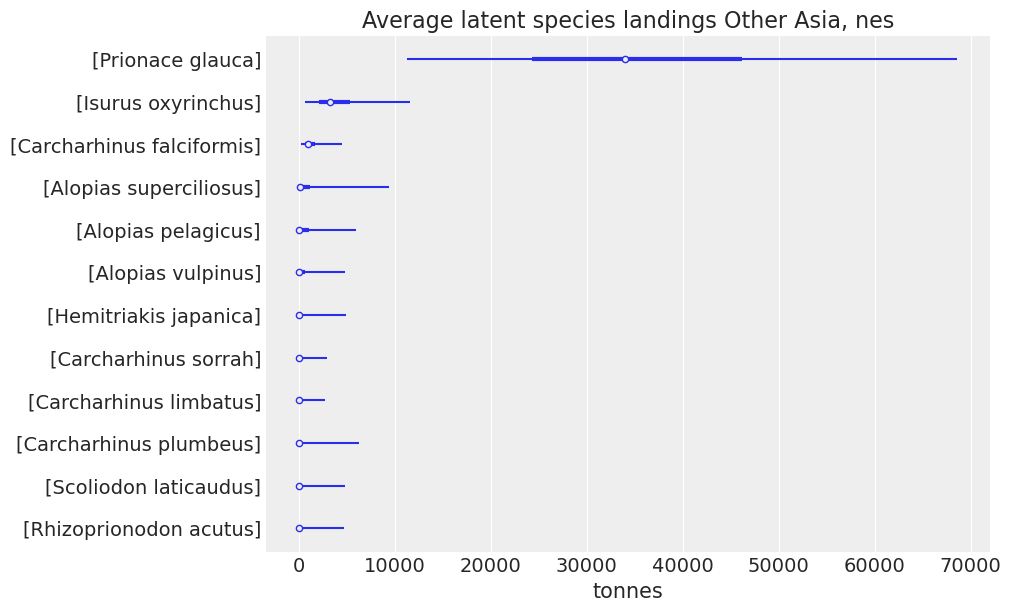

In [126]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>5].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [127]:
sppxxx

array(['Prionace glauca', 'Isurus oxyrinchus', 'Carcharhinus falciformis',
       'Alopias superciliosus', 'Alopias pelagicus', 'Alopias vulpinus',
       'Hemitriakis japanica', 'Carcharhinus sorrah',
       'Carcharhinus limbatus', 'Carcharhinus plumbeus',
       'Scoliodon laticaudus', 'Rhizoprionodon acutus'], dtype=object)

In [128]:
Obs_spp_data.loc[counx]

Reported_landings
species                                    
Carcharhinus falciformis         515.774873
Carcharhinus longimanus            2.044343
Isurus oxyrinchus               1765.483998
Prionace glauca                27910.673844

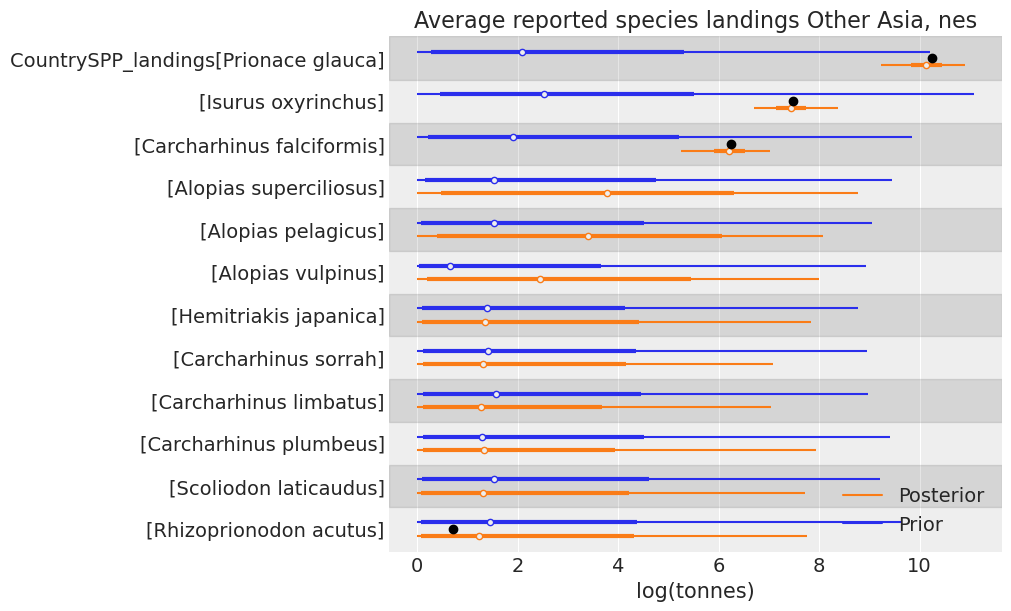

In [129]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).median(("chain", "draw")).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) if x in rowlist else -1 for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

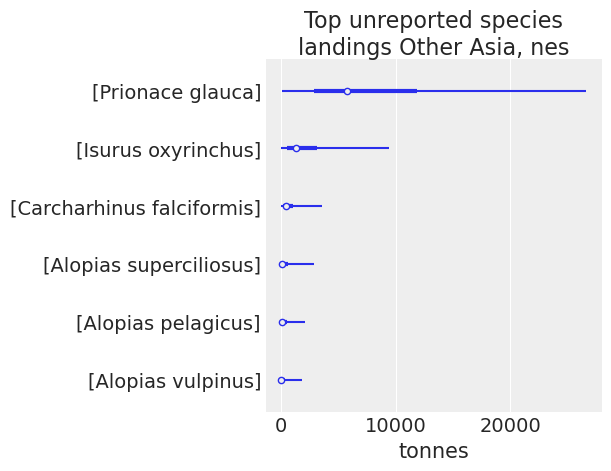

In [130]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

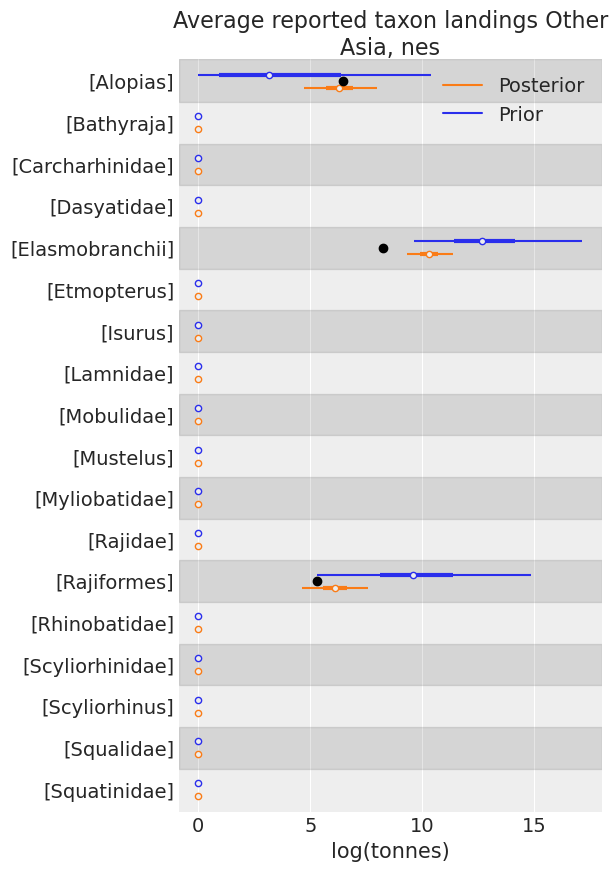

In [131]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/2935711675.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


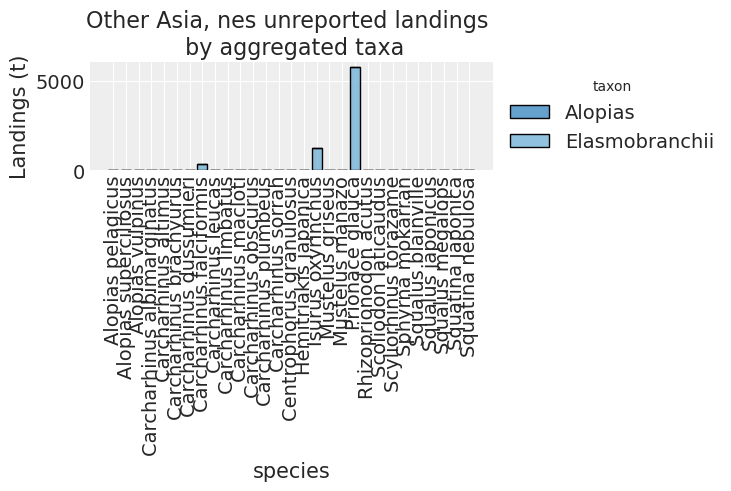

In [132]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

# Look at surprising latent species details

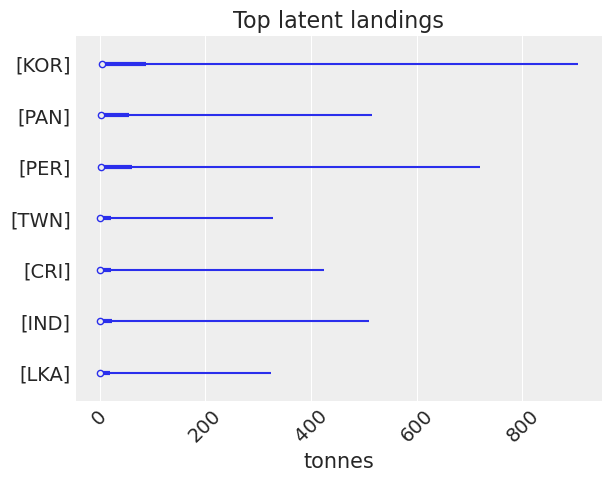

In [133]:
# Select top 10% of landed 'Pseudocarcharias kamoharai'
tmp = idata_trade_x.posterior['latent_species_landings'].sel(species='Pseudocarcharias kamoharai').median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
ex_landed = tmp[tmp>np.quantile(tmp,0.90)].exporter

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['latent_species_landings'].sel(exporter=ex_landed,
                                species='Pseudocarcharias kamoharai').rename('')
ax = az.plot_forest(tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title="Top latent landings",
    xlabel="tonnes",
    ylabel="",
);
#ax[0].set_xlim(0,.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_crocodlie_shark.jpg',dpi=300);

## look at Indonesia

In [134]:
counx = 'IDN'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/695665550.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


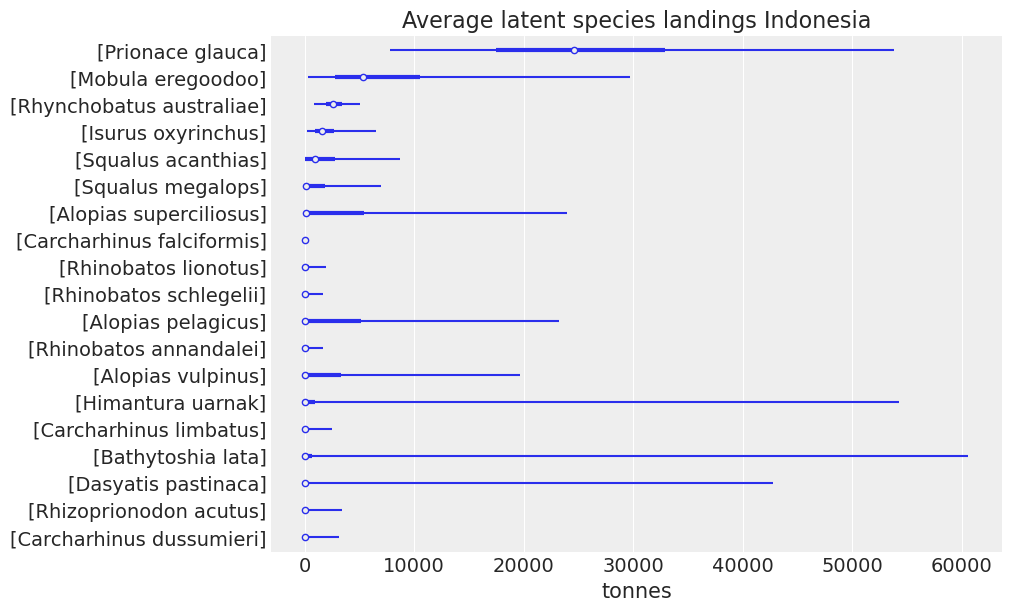

In [135]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>5].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [136]:
sppxxx

array(['Prionace glauca', 'Mobula eregoodoo', 'Rhynchobatus australiae',
       'Isurus oxyrinchus', 'Squalus acanthias', 'Squalus megalops',
       'Alopias superciliosus', 'Carcharhinus falciformis',
       'Rhinobatos lionotus', 'Rhinobatos schlegelii',
       'Alopias pelagicus', 'Rhinobatos annandalei', 'Alopias vulpinus',
       'Himantura uarnak', 'Carcharhinus limbatus', 'Bathytoshia lata',
       'Dasyatis pastinaca', 'Rhizoprionodon acutus',
       'Carcharhinus dussumieri'], dtype=object)

In [137]:
Obs_spp_data.loc[counx]

Reported_landings
species                                    
Carcharhinus falciformis          29.447391
Prionace glauca                18086.336722
Rhynchobatus australiae         2778.426648

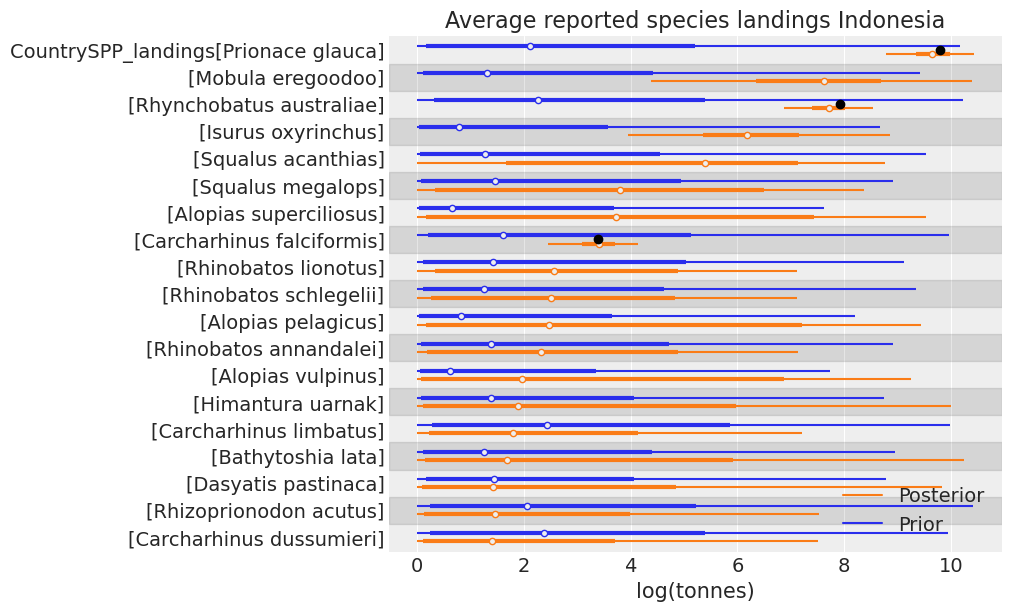

In [138]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
rowlist = list(idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).median(("chain", "draw")).species.to_numpy())
xtmp = Obs_spp_data.loc[counx].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) if x in rowlist else -1 for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

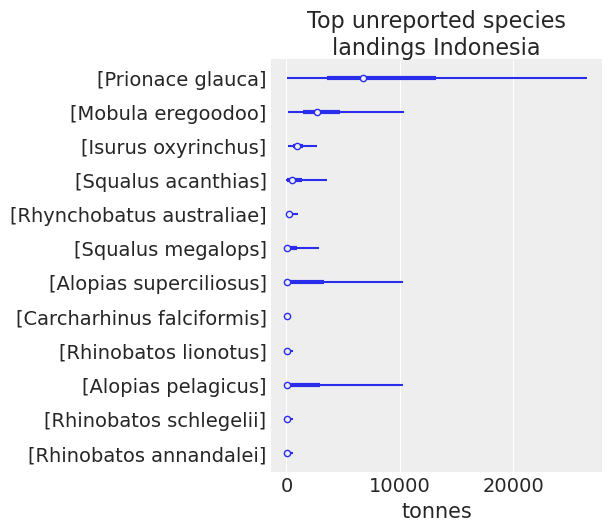

In [139]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

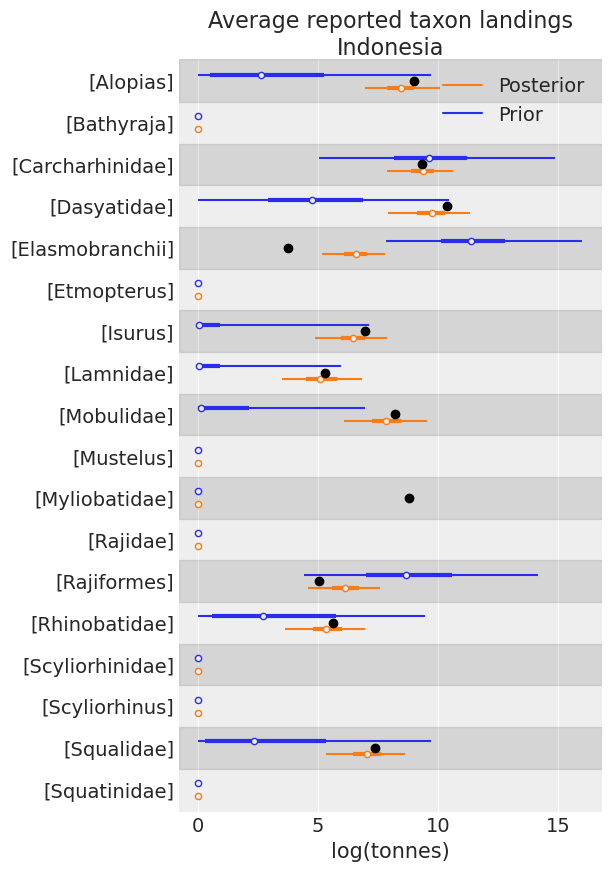

In [140]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_23797/2935711675.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


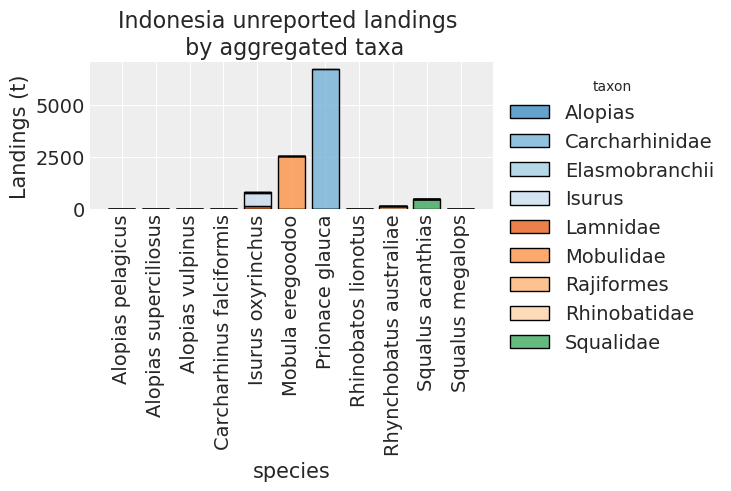

In [141]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

In [134]:
counx = 'NZL'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_36964/3034982867.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


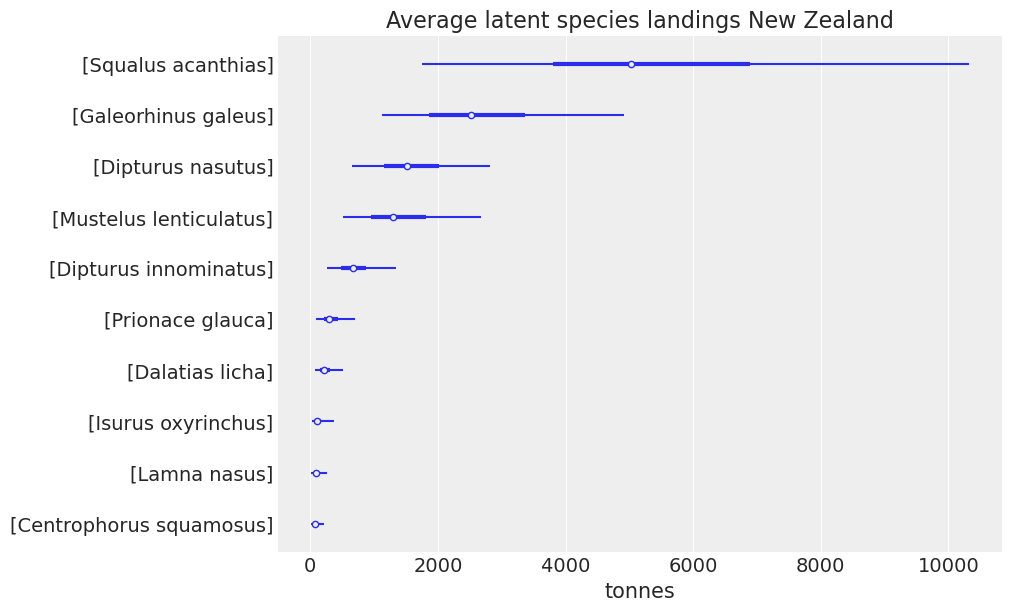

In [168]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>50].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [169]:
sppxxx

array(['Squalus acanthias', 'Galeorhinus galeus', 'Dipturus nasutus',
       'Mustelus lenticulatus', 'Dipturus innominatus', 'Prionace glauca',
       'Dalatias licha', 'Isurus oxyrinchus', 'Lamna nasus',
       'Centrophorus squamosus'], dtype=object)

In [170]:
Obs_spp_data.loc[counx]

Reported_landings
species                                     
Alopias vulpinus                   16.103961
Amblyraja georgiana                 1.000000
Bathyraja eatonii                   1.000000
Bathyraja maccaini                  1.000000
Carcharhinus brachyurus            10.663349
Centrophorus squamosus             46.348833
Centroscymnus owstonii              1.122462
Centroselachus crepidater           9.226973
Dalatias licha                    164.331474
Dipturus innominatus              665.524669
Dipturus nasutus                 1773.242377
Galeorhinus galeus               3090.237967
Gollum attenuatus                   3.554254
Isurus oxyrinchus                  61.445849
Lamna nasus                        56.731532
Mustelus lenticulatus            1393.689285
Notorynchus cepedianus             10.130782
Prionace glauca                   244.956358
Sphyrna zygaena                    11.627329
Squalus acanthias                5687.095788

array(['Squalus acanthias', 'Galeorhinus galeus', 'Dipturus nasutus',
       'Mustelus lenticulatus', 'Dipturus innominatus', 'Prionace glauca',
       'Dalatias licha', 'Isurus oxyrinchus', 'Lamna nasus',
       'Centrophorus squamosus'], dtype='<U22')

Reported_landings
species                                  
Squalus acanthias             5687.095788
Galeorhinus galeus            3090.237967
Dipturus nasutus              1773.242377
Mustelus lenticulatus         1393.689285
Dipturus innominatus           665.524669
Prionace glauca                244.956358
Dalatias licha                 164.331474
Isurus oxyrinchus               61.445849
Lamna nasus                     56.731532
Centrophorus squamosus          46.348833

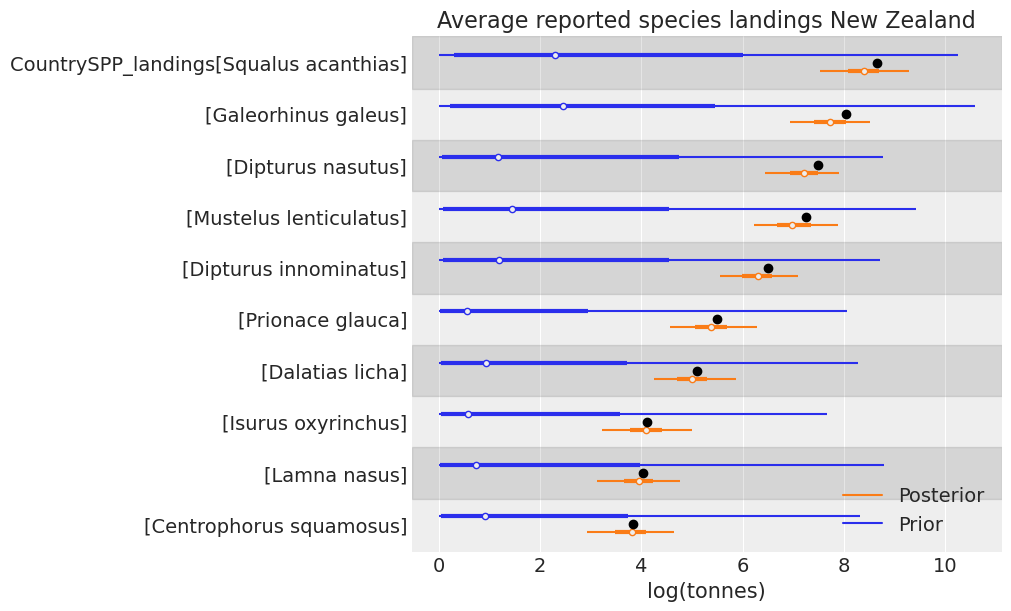

In [186]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
tmp = idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).median(("chain", "draw"))
rowlist = list(tmp.species.to_numpy())
xtmp = Obs_spp_data.loc[counx].loc[rowlist].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) if x in rowlist else -1 for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

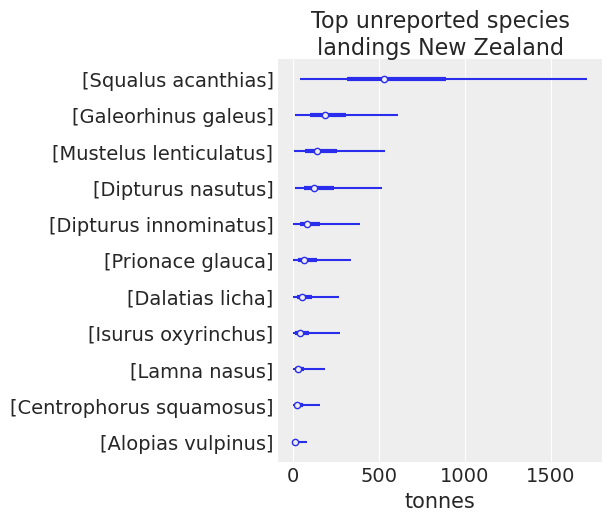

In [148]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

In [204]:
taxon_shortlist = idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter='ESP').taxon.to_numpy()

In [207]:
Obs_tax_data.loc[counx]

array([0.91343982, 5.01353944, 4.17090094, 1.33249143, 5.6426436 ])

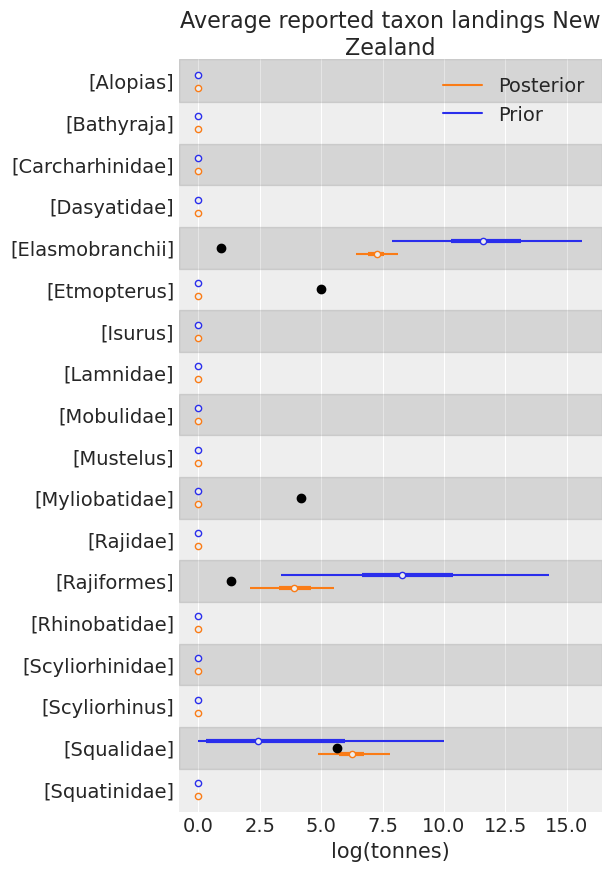

In [208]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_36964/2935711675.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


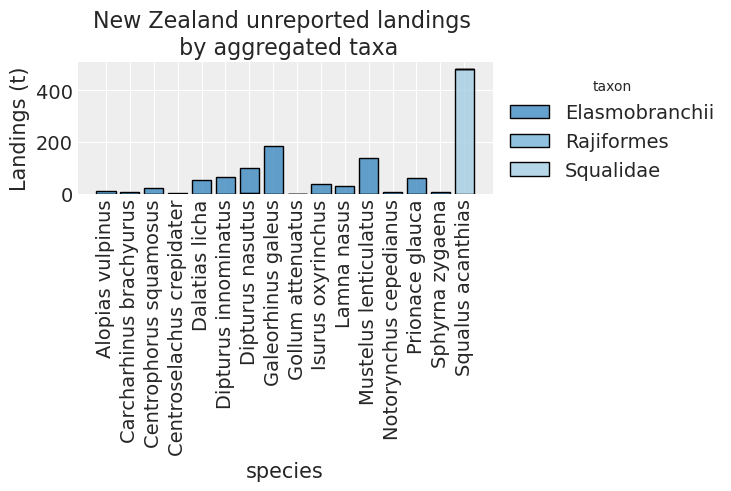

In [209]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

In [211]:
biggest_countries

array(['AGO', 'ARE', 'ARG', 'AUS', 'BEL', 'BGD', 'BLZ', 'BRA', 'CAN',
       'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CUB', 'DEU', 'DNK', 'ECU',
       'ESP', 'FRA', 'GBR', 'GHA', 'GRC', 'HKG', 'IDN', 'IND', 'IRL',
       'IRN', 'ITA', 'JPN', 'KOR', 'LBY', 'LKA', 'MAR', 'MDG', 'MEX',
       'MOZ', 'MRT', 'MYS', 'NAM', 'NGA', 'NLD', 'NOR', 'NZL', 'OMN',
       'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'RUS', 'SEN', 'SGP',
       'SLE', 'SWE', 'THA', 'TTO', 'TUN', 'TWN', 'TZA', 'URY', 'USA',
       'VEN', 'VUT', 'YEM', 'ZAF'], dtype=object)

In [212]:
counx = 'VUT'
couny = biggest_countries_long[list(biggest_countries).index(counx)]

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_36964/3250806557.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


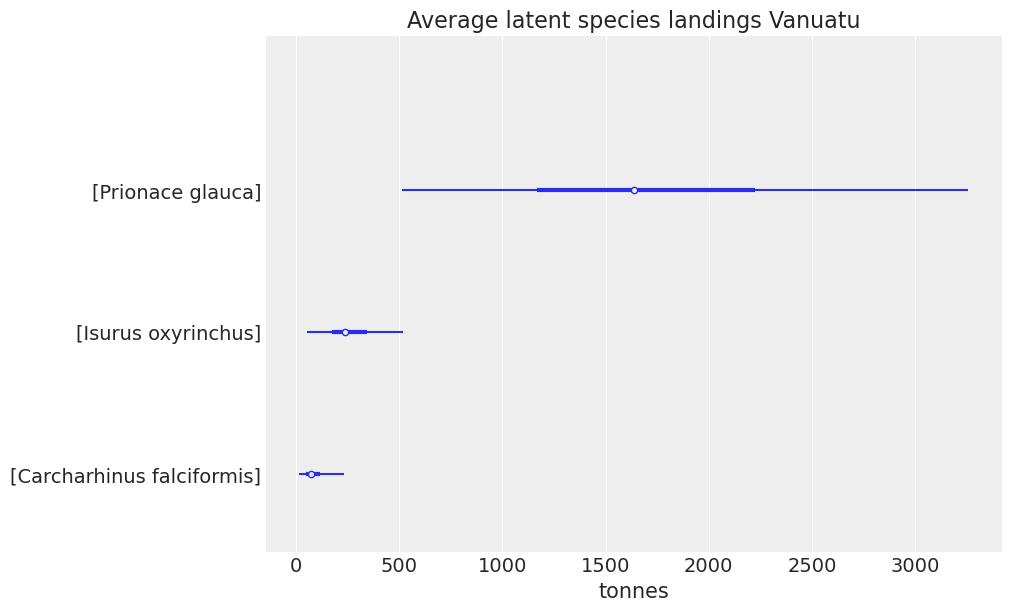

In [222]:


# Select only species estimated to have some landings
tmp = idata_trade_x.posterior['latent_species_landings'].median(("chain", "draw")).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppxxx = tmp[tmp>50].species.to_numpy()

ax = az.plot_forest(idata_trade_x.posterior['latent_species_landings'].sel(exporter=counx, species=sppxxx).rename(''),
                    #transform=np.log1p,
                    combined=True,
                    figsize=(10,6)
                   )
ax[0].set(
    title="Average latent species landings "+couny,
    xlabel="tonnes",
    ylabel="",
)
#ax[0].set_xlim(0,6000)
plt.tight_layout()
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Latent_landings_.jpg',dpi=300);

In [214]:
sppxxx

array(['Prionace glauca', 'Isurus oxyrinchus', 'Carcharhinus falciformis'],
      dtype=object)

In [215]:
Obs_spp_data.loc[counx]

Reported_landings
species                                    
Carcharhinus falciformis          45.593442
Isurus oxyrinchus                200.231925
Prionace glauca                 1831.350132

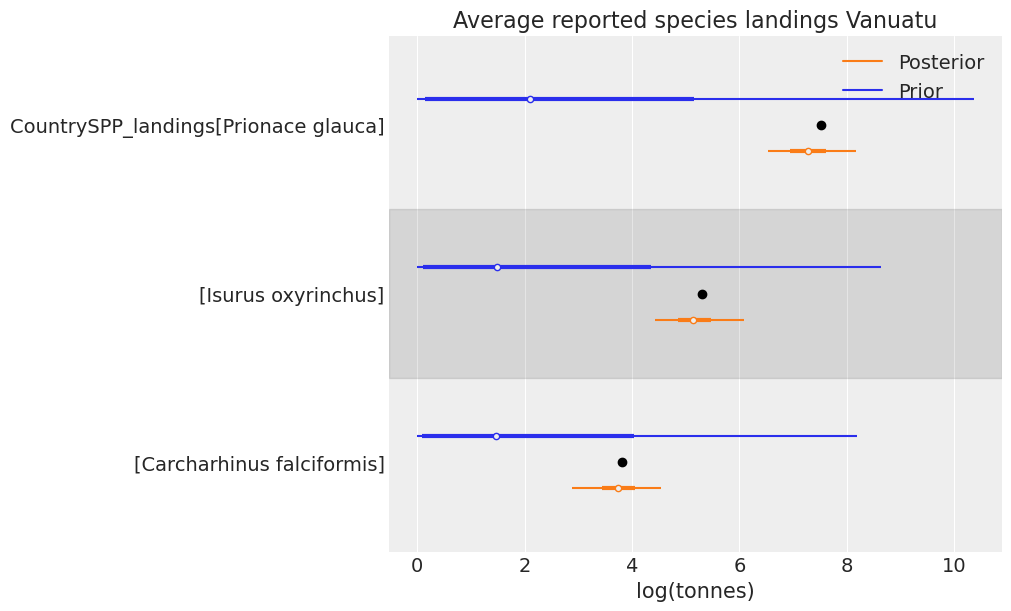

In [216]:
ax = az.plot_forest([idata_trade_x.prior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx),
                    idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx)],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    figsize=(10, 6)
                   )


# Add observed average landings reported to species
tmp = idata_trade_x.posterior['CountrySPP_landings'].sel(exporter=counx, species=sppxxx).median(("chain", "draw"))
rowlist = list(tmp.species.to_numpy())
xtmp = Obs_spp_data.loc[counx].loc[rowlist].reset_index()
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) if x in rowlist else -1 for x in xtmp.species])]
plt.scatter(np.log(xtmp.Reported_landings),ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported species landings "+couny,
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_species_landings.jpg',dpi=300);

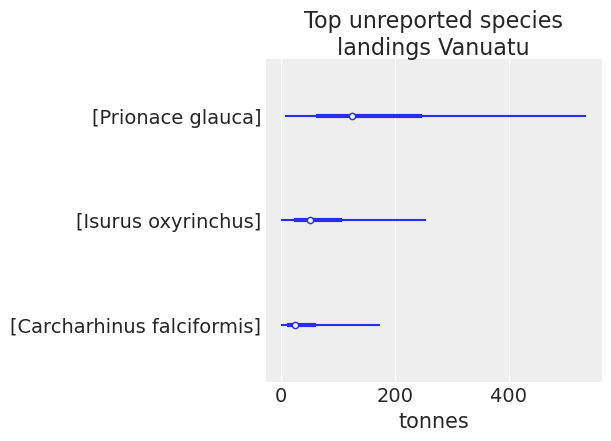

In [217]:
# Select top 10% of unreported species
tmp = Net_spp_landings.median(('chain','draw')).sel(exporter=counx)
tmp = tmp.sortby(tmp, ascending=False)
sppx_un = tmp[tmp>10].species

# Plot unreported species-level landings
ax = az.plot_forest(Net_spp_landings.sel(exporter=counx, species=sppx_un).rename(''),
                    #transform=np.log1p,
                    #figsize=(10, 20)
                   )
ax[0].set(
    title="Top unreported species landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="tonnes",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Unreported_landings.jpg',dpi=300);

In [218]:
taxon_shortlist = idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter='ESP').taxon.to_numpy()

In [219]:
Obs_tax_data.loc[counx]

Reported_landings
taxon                            
Elasmobranchii          32.716843

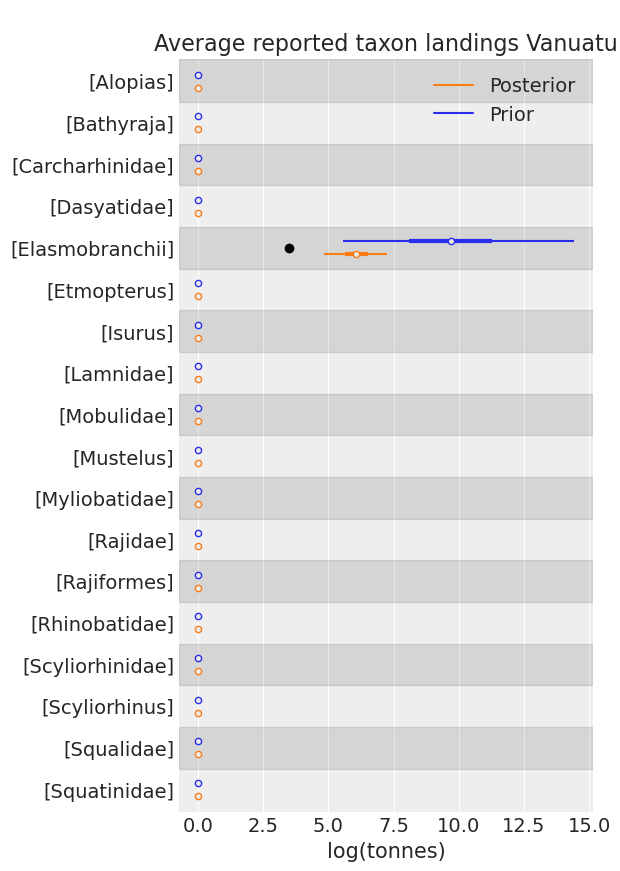

In [220]:
# Select only taxa estimated to have some landings
taxxx = taxon_shortlist[idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx)>0]

ax = az.plot_forest([idata_trade_x.prior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename(''),
                    idata_trade_x.posterior['CountryTaxon_landings'].sel(exporter=counx, taxon=taxxx).rename('')],
                    model_names=["Prior", "Posterior"],
                    transform=np.log1p,
                    #figsize=(10, 20)
                   )

# Add observed average landings reported to species
xtmp = np.log(Obs_tax_data.loc[counx].Reported_landings.to_numpy())
rowlist = list(idata_trade_x.posterior['CountryTaxon_landings'].mean(("chain", "draw")).sel(exporter=counx, taxon=taxxx).taxon.to_numpy())
ytmp = ax[0].yaxis.get_majorticklocs()[::-1][np.array([rowlist.index(x) for x in Obs_tax_data.loc[counx].index])]
# Plot observed aggregations
plt.scatter(xtmp,ytmp,c='black',zorder=10)

ax[0].set(
    title="Average reported taxon landings "+biggest_countries_long[list(biggest_countries).index(counx)],
    xlabel="log(tonnes)",
    ylabel="",
)
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Reported_taxon_landings.jpg',dpi=300);

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_36964/2935711675.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


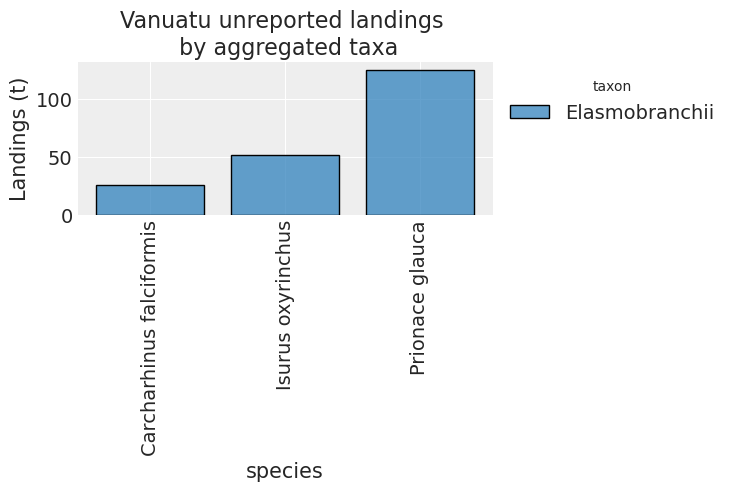

In [221]:
# Posterior taxon landings by species
PostTaxonSpp = (
        idata_trade_x.posterior["CountryTaxon_SPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])
    ).to_dataframe()
PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]

# Posterior species landings
PostSpp = (
        idata_trade_x.posterior["CountrySPP_landings"]
        .median(("chain", "draw"))
        .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
        .sel(exporter=counx)
        .drop_vars(['exporter'])-1
    ).to_dataframe()
PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]


# Remove species not present
#zindx = post_species_land>0

# One liner to create a stacked bar chart.
ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('Landings (t)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.savefig(os.getcwd()+'/Figures/Exporters/'+couny+'_Species_taxon_landings.jpg',dpi=300);

In [ ]:
FLSL1 = FLSL[agg_indx=1]

In [ ]:
FLSL1.sum(spp)

In [ ]:
FLSL[agg_indx=2]

In [ ]:
FLSL[agg_indx=3]

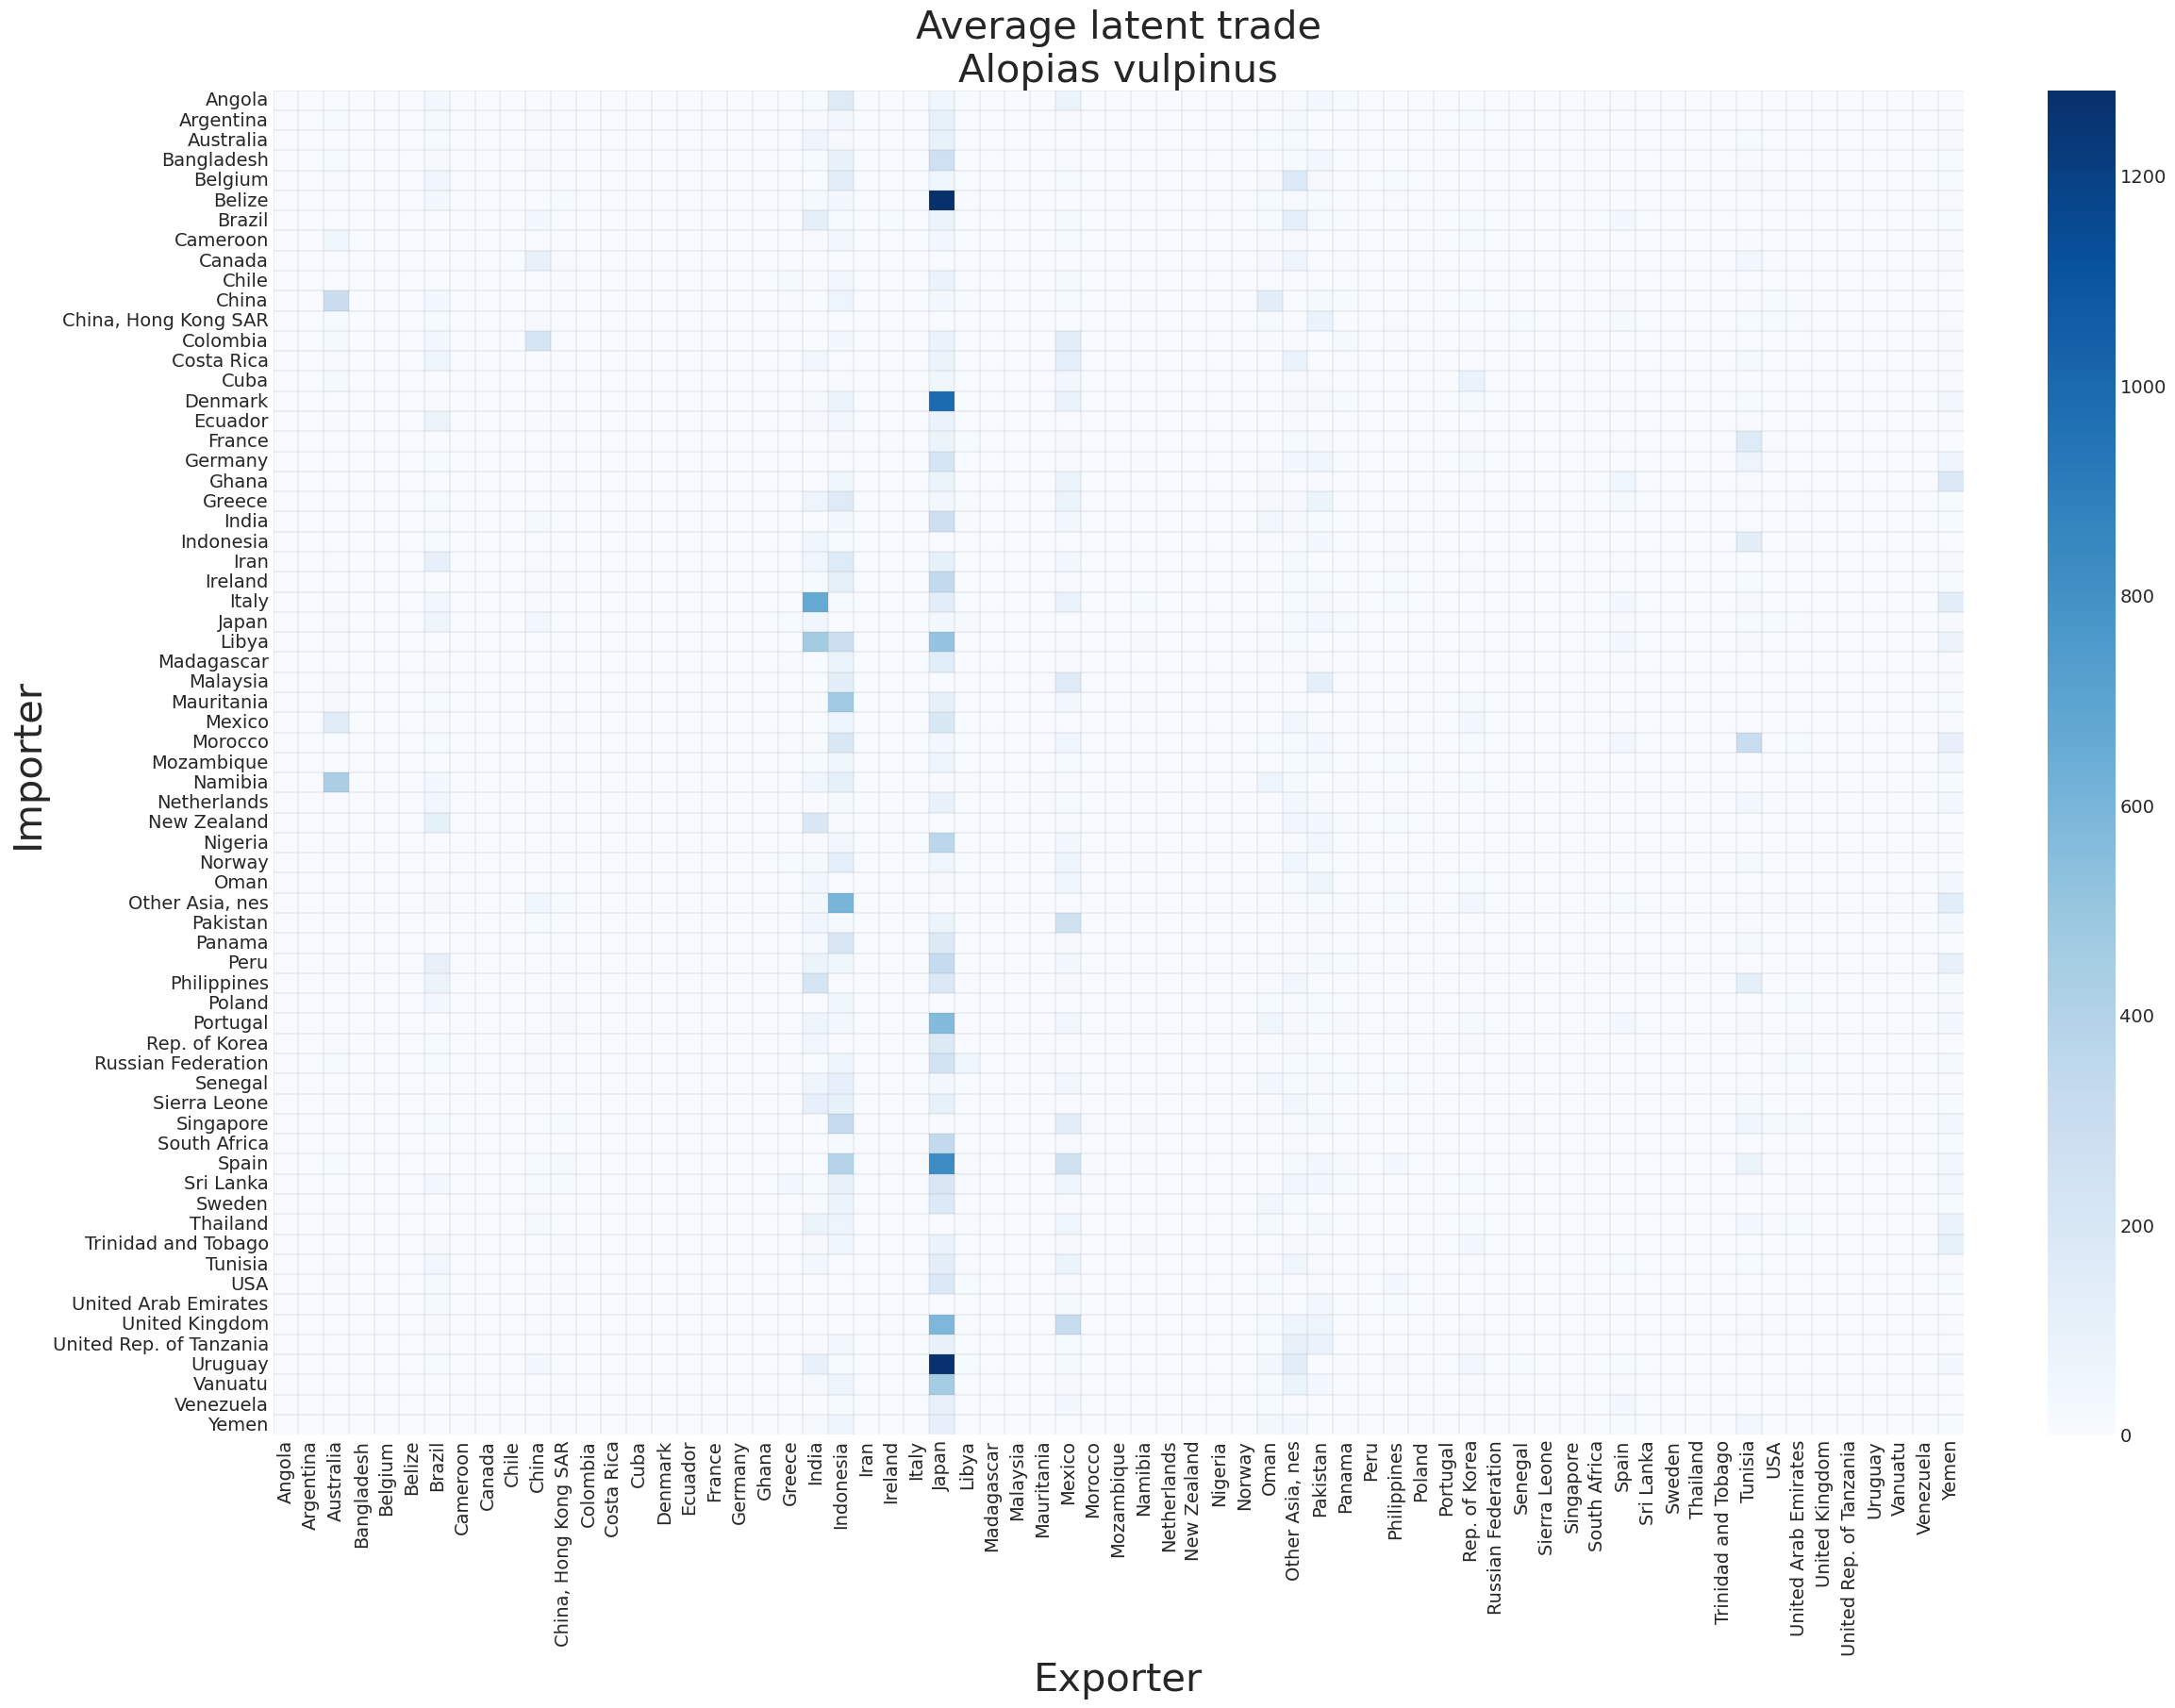

In [70]:
sppx = species_[10]

post_latent_trade = (
    idata_trade_x.posterior["amount_exported"]
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                    "Importer": ("importer", biggest_countries_long)})
    .drop_vars(['exporter','importer'])
    .sel(species=sppx)
)

_, ax = plt.subplots(figsize=(23, 18))
sns.heatmap(
    post_latent_trade.to_dataframe().drop(["species"], axis="columns")
    .reset_index().drop(['exporter','importer'],axis=1)
    .set_index(['Exporter','Importer']).unstack()
    .droplevel(0, axis=1)
    .T,
    ax=ax,
    cmap=sns.color_palette("Blues", as_cmap=True),
)
ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax.set_title("Average latent trade\n"+sppx, fontsize=30)
ax.set_xlabel("Exporter", fontsize=30)
ax.set_ylabel("Importer", fontsize=30);

In [72]:
species_

array(['Aetobatus flagellum', 'Aetobatus narinari', 'Aetobatus ocellatus',
       'Aetomylaeus bovinus', 'Aetomylaeus maculatus',
       'Aetomylaeus milvus', 'Aetomylaeus nichofii',
       'Aetomylaeus vespertilio', 'Alopias pelagicus',
       'Alopias superciliosus', 'Alopias vulpinus', 'Amblyraja georgiana',
       'Amblyraja hyperborea', 'Amblyraja jenseni', 'Amblyraja radiata',
       'Amblyraja taaf', 'Aptychotrema rostrata',
       'Aptychotrema vincentiana', 'Arhynchobatis asperrimus',
       'Atlantoraja castelnaui', 'Atlantoraja cyclophora',
       'Bathyraja brachyurops', 'Bathyraja eatonii',
       'Bathyraja interrupta', 'Bathyraja irrasa', 'Bathyraja lindbergi',
       'Bathyraja maccaini', 'Bathyraja macloviana', 'Bathyraja murrayi',
       'Bathyraja richardsoni', 'Bathyraja shuntovi',
       'Bathyraja spinicauda', 'Bathytoshia centroura',
       'Bathytoshia lata', 'Beringraja binoculata', 'Beringraja inornata',
       'Beringraja rhina', 'Brevitrygon walga', 'Brochir

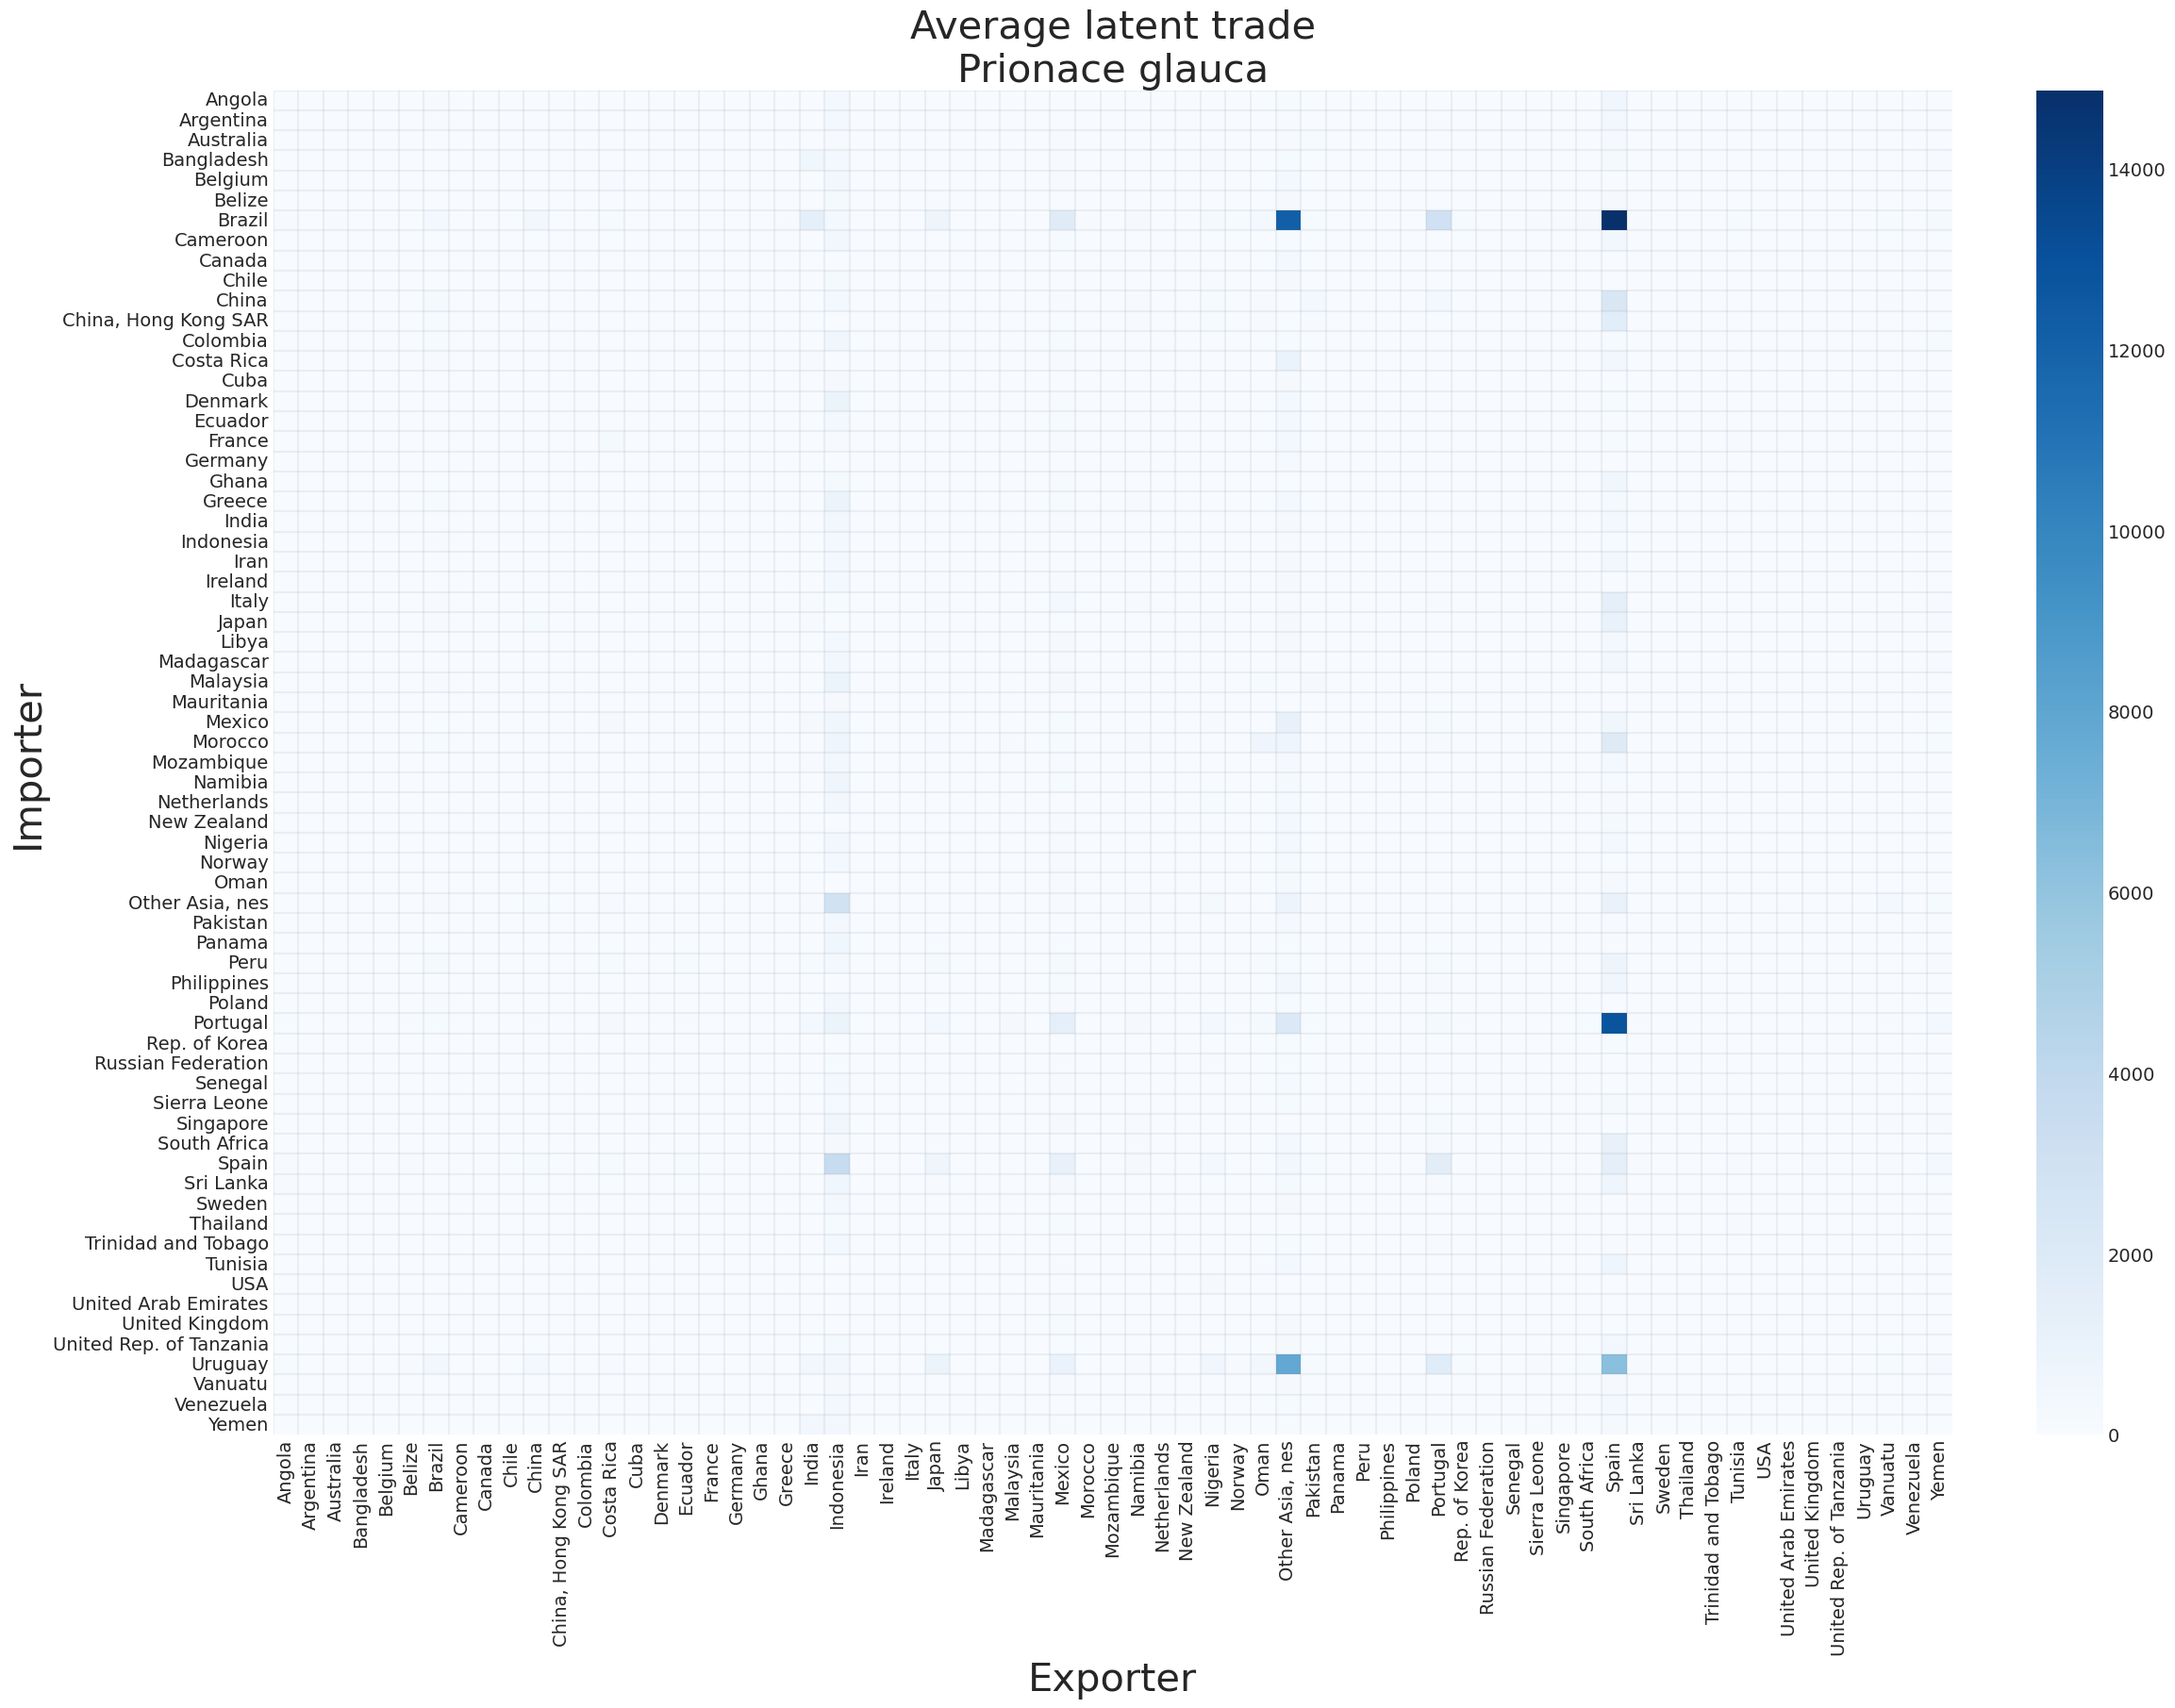

In [73]:
sppx = 'Prionace glauca'

post_latent_trade = (
    idata_trade_x.posterior["amount_exported"]
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                    "Importer": ("importer", biggest_countries_long)})
    .drop_vars(['exporter','importer'])
    .sel(species=sppx)
)

_, ax = plt.subplots(figsize=(23, 18))
sns.heatmap(
    post_latent_trade.to_dataframe().drop(["species"], axis="columns")
    .reset_index().drop(['exporter','importer'],axis=1)
    .set_index(['Exporter','Importer']).unstack()
    .droplevel(0, axis=1)
    .T,
    ax=ax,
    cmap=sns.color_palette("Blues", as_cmap=True),
)
ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax.set_title("Average latent trade\n"+sppx, fontsize=30)
ax.set_xlabel("Exporter", fontsize=30)
ax.set_ylabel("Importer", fontsize=30);

In [ ]:
#"""

for counx in country_:
    try:
        # Posterior taxon landings by species
        PostTaxonSpp = (
                idata_trade_x.posterior["CountryTaxon_SPP_landings"]
                .median(("chain", "draw"))
                .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
                .sel(exporter=counx)
                .drop_vars(['exporter'])
            ).to_dataframe()
        PostTaxonSpp = PostTaxonSpp[PostTaxonSpp.CountryTaxon_SPP_landings>1]
        
        # Posterior species landings
        PostSpp = (
                idata_trade_x.posterior["CountrySPP_landings"]
                .median(("chain", "draw"))
                .assign_coords({"Exporter": ("exporter", biggest_countries_long)})
                .sel(exporter=counx)
                .drop_vars(['exporter'])-1
            ).to_dataframe()
        PostSpp = PostSpp[PostSpp.CountrySPP_landings>0]
        
        
        # Remove species not present
        #zindx = post_species_land>0
        
        # One liner to create a stacked bar chart.
        ax = sns.histplot(PostTaxonSpp, x='species', hue='taxon', weights='CountryTaxon_SPP_landings',
                     multiple='stack', palette='tab20c', shrink=0.8)
        ax.set_ylabel('Landings (t)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_title(biggest_countries_long[list(country_).index(counx)]+' unreported landings \n by aggregated taxa')
        # Fix the legend so it's not on top of the bars.
        legend = ax.get_legend()
        legend.set_bbox_to_anchor((1, 1))
        plt.savefig(os.getcwd()+'/Figures/Exporters/'+counx+'_unreported_by_taxa.jpg',dpi=300)
        plt.close()

    except TypeError:
        pass
    except AttributeError:
        pass

#"""

In [ ]:

for sppx in species_:
    try:
        post_latent_trade = (
            idata_trade_x.posterior["amount_exported"]
            .mean(("chain", "draw"))
            .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                            "Importer": ("importer", biggest_countries_long)})
            .drop_vars(['exporter','importer'])
            .sel(species=sppx)
        )

        _, ax = plt.subplots(figsize=(23, 18))
        sns.heatmap(
            post_latent_trade.to_dataframe().drop(["species"], axis="columns")
            .reset_index().drop(['exporter','importer'],axis=1)
            .set_index(['Exporter','Importer']).unstack()
            .droplevel(0, axis=1)
            .T,
            ax=ax,
            cmap=sns.color_palette("Blues", as_cmap=True),
        )
        ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
        ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

        ax.set_title("Average latent trade\n"+sppx, fontsize=30)
        ax.set_xlabel("Exporter", fontsize=30)
        ax.set_ylabel("Importer", fontsize=30)
        plt.savefig(os.getcwd()+'/Figures/Species/'+sppx+'_latent_trade.jpg',dpi=300)
        plt.close()
    except:
        pass

In [104]:
idata_trade_x.posterior['CountryTaxon_landings'].shape

(1, 1000, 67, 18)

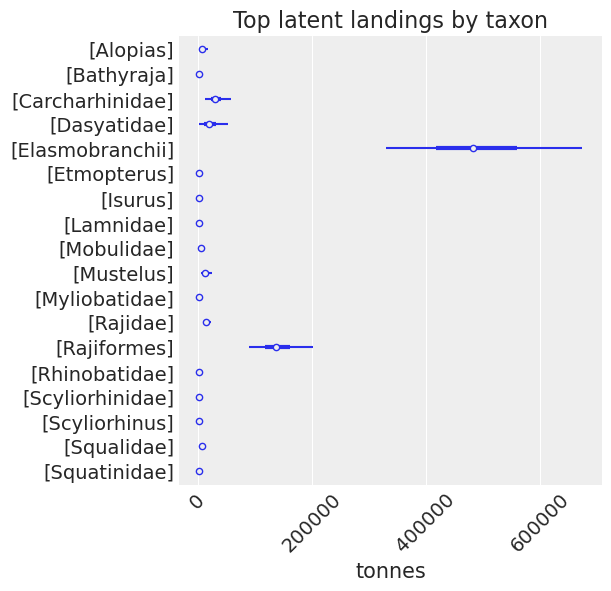

In [107]:
# Plot top taxa traded

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['CountryTaxon_landings'].sum(('exporter')).rename('')
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title="Top latent landings by taxon",
    xlabel="tonnes",
    ylabel="",
);
#ax[0].set_xlim(0,.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_species_proportions.jpg',dpi=300);

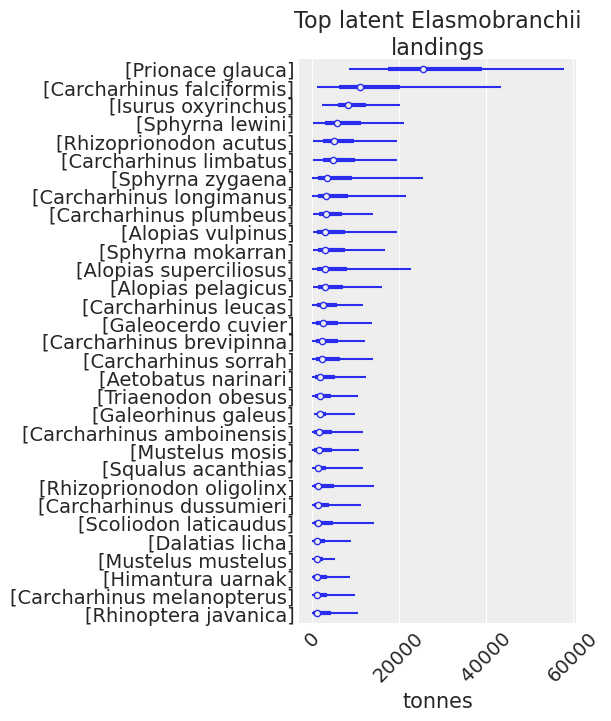

In [113]:
# Plot top taxa traded
taxax = 'Elasmobranchii'
# Select top 10% of landedspecies
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax,species=sppx_landed).rename('')
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title='Top latent '+taxax+' landings',
    xlabel="tonnes",
    ylabel="",
);
#ax[0].set_xlim(0,.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_species_proportions.jpg',dpi=300);




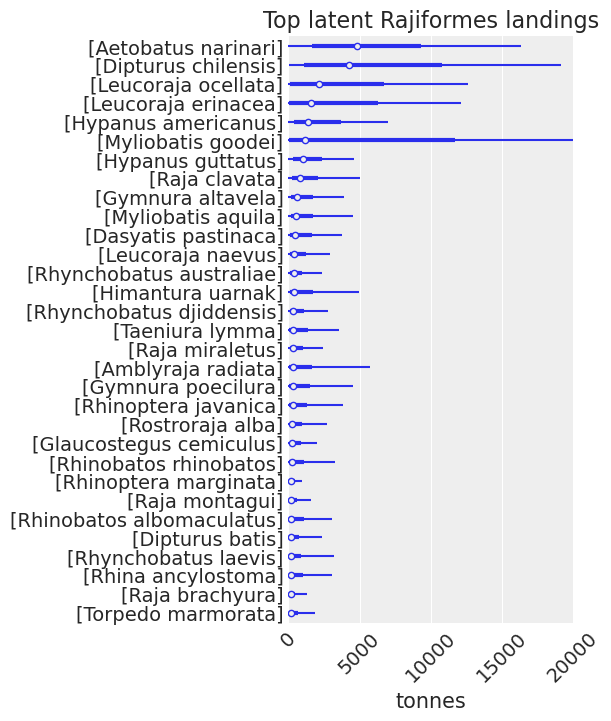

In [119]:
# Plot top taxa traded
taxax = 'Rajiformes'
# Select top 10% of landedspecies
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax,species=sppx_landed).rename('')
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title='Top latent '+taxax+' landings',
    xlabel="tonnes",
    ylabel="",
);
ax[0].set_xlim(0,20000)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_species_proportions.jpg',dpi=300);




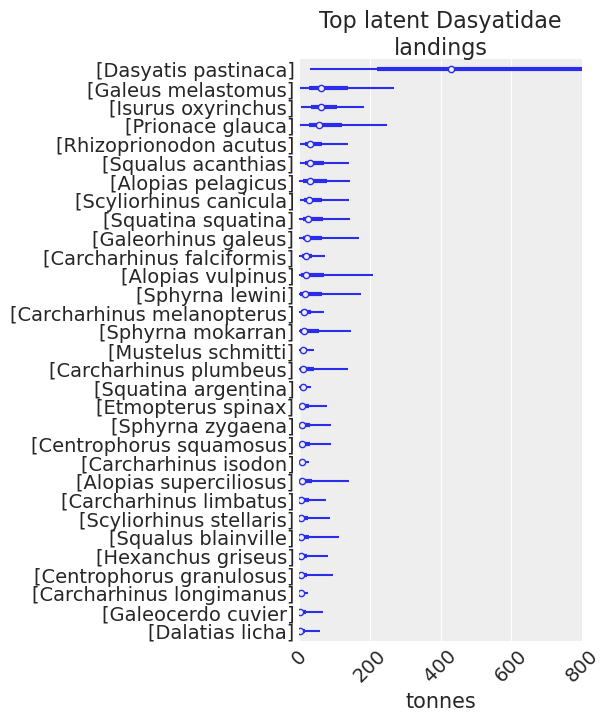

In [118]:
# Plot top taxa traded
taxax = 'Dasyatidae'
# Select top 10% of landedspecies
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_landed = tmp[tmp>np.quantile(tmp,0.90)].species

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['CountryTaxon_SPP_landings'].sum(('exporter')).sel(taxon=taxax,species=sppx_landed).rename('')
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title='Top latent '+taxax+' landings',
    xlabel="tonnes",
    ylabel="",
);
ax[0].set_xlim(0,800)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_species_proportions.jpg',dpi=300);




In [ ]:
# Plot top taxa traded

# = = = = = Plot latent species landings
tmp = idata_trade_x.posterior['amount_exported'].sel(species=('Aetobatus narinari'))
ax = az.plot_forest(
    #tmp/tmp.median(('chain','draw')).sum(),
    tmp,
                    hdi_prob=0.9,
                    #transform=np.log1p,
                    #figsize=(10, 20)
               
                   )
ax[0].set(
    title="Top latent landings by taxon",
    xlabel="tonnes",
    ylabel="",
);
#ax[0].set_xlim(0,.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig(os.getcwd()+'/Figures/Global/'+'Latent_species_proportions.jpg',dpi=300);

In [127]:
idata_trade_x.posterior['amount_exported'].sel(
    species=('Aetobatus narinari')).mean(('chain','draw'))
    .to_dataframe().reset_index().to_csv("species_maptest.csv"
    )

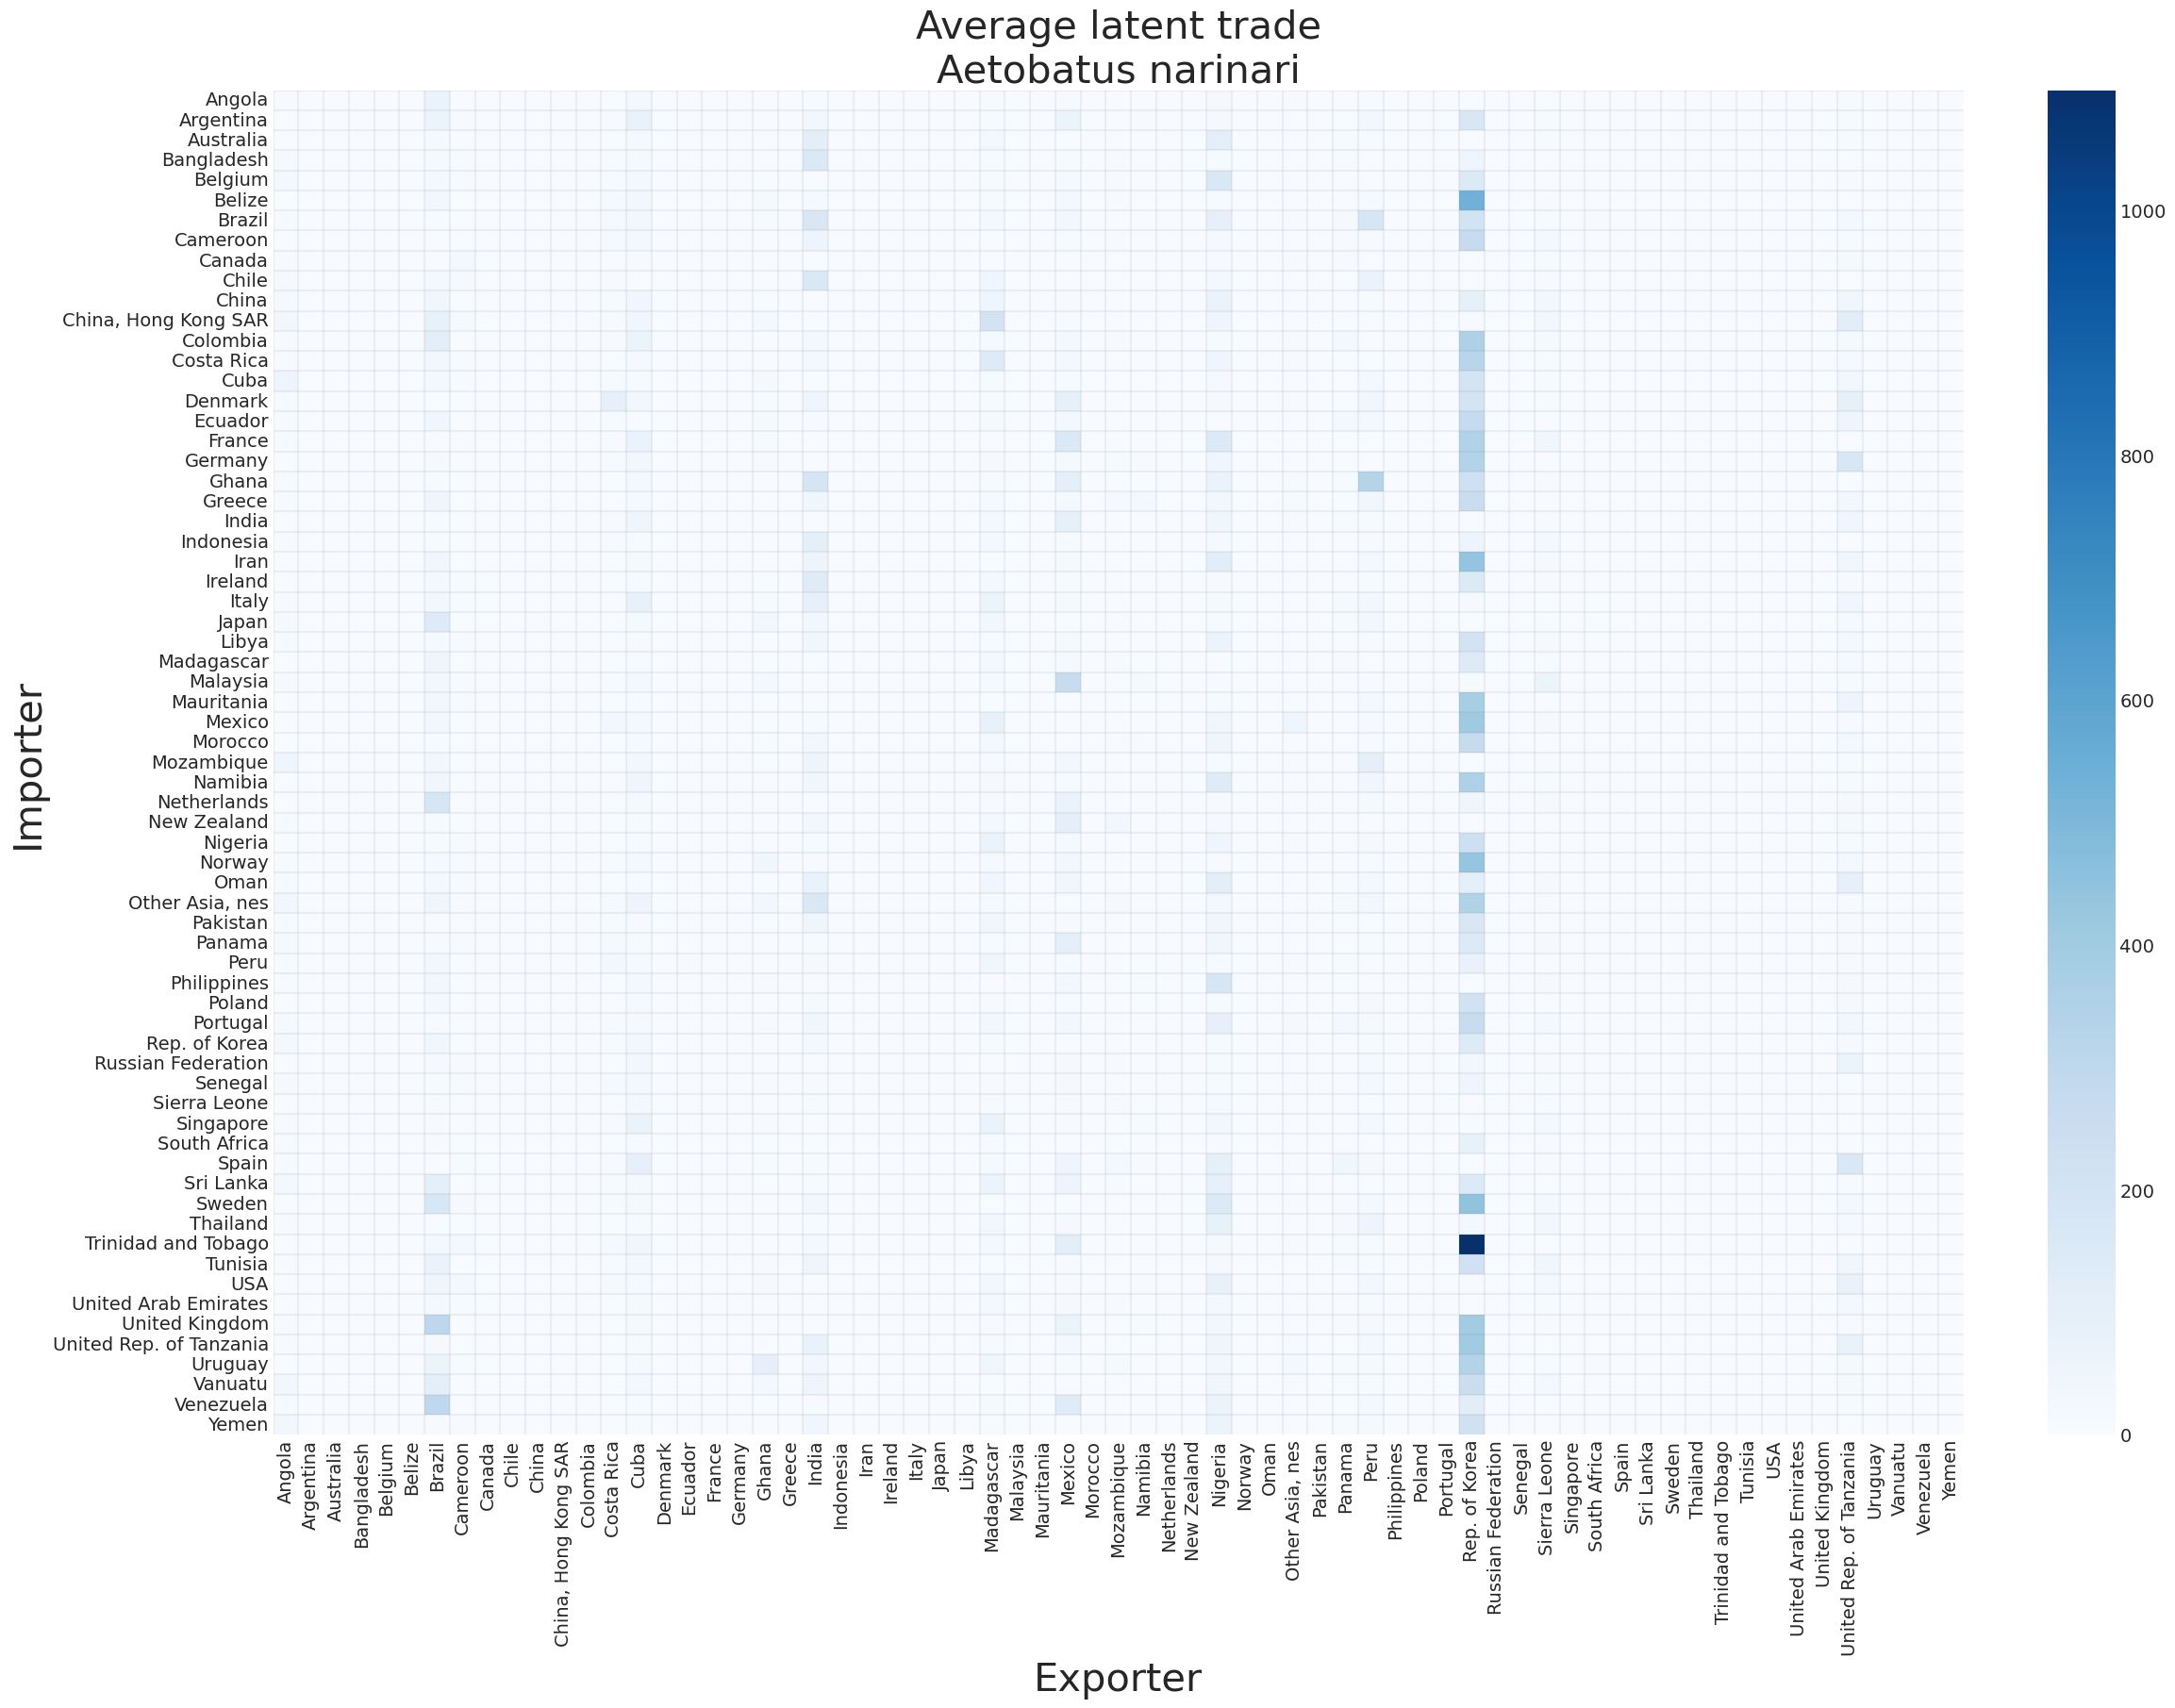

In [129]:
sppx = 'Aetobatus narinari'

post_latent_trade = (
    idata_trade_x.posterior["amount_exported"]
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                    "Importer": ("importer", biggest_countries_long)})
    .drop_vars(['exporter','importer'])
    .sel(species=sppx)
)

_, ax = plt.subplots(figsize=(23, 18))
sns.heatmap(
    post_latent_trade.to_dataframe().drop(["species"], axis="columns")
    .reset_index().drop(['exporter','importer'],axis=1)
    .set_index(['Exporter','Importer']).unstack()
    .droplevel(0, axis=1)
    .T,
    ax=ax,
    cmap=sns.color_palette("Blues", as_cmap=True),
)
ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax.set_title("Average latent trade\n"+sppx, fontsize=30)
ax.set_xlabel("Exporter", fontsize=30)
ax.set_ylabel("Importer", fontsize=30);

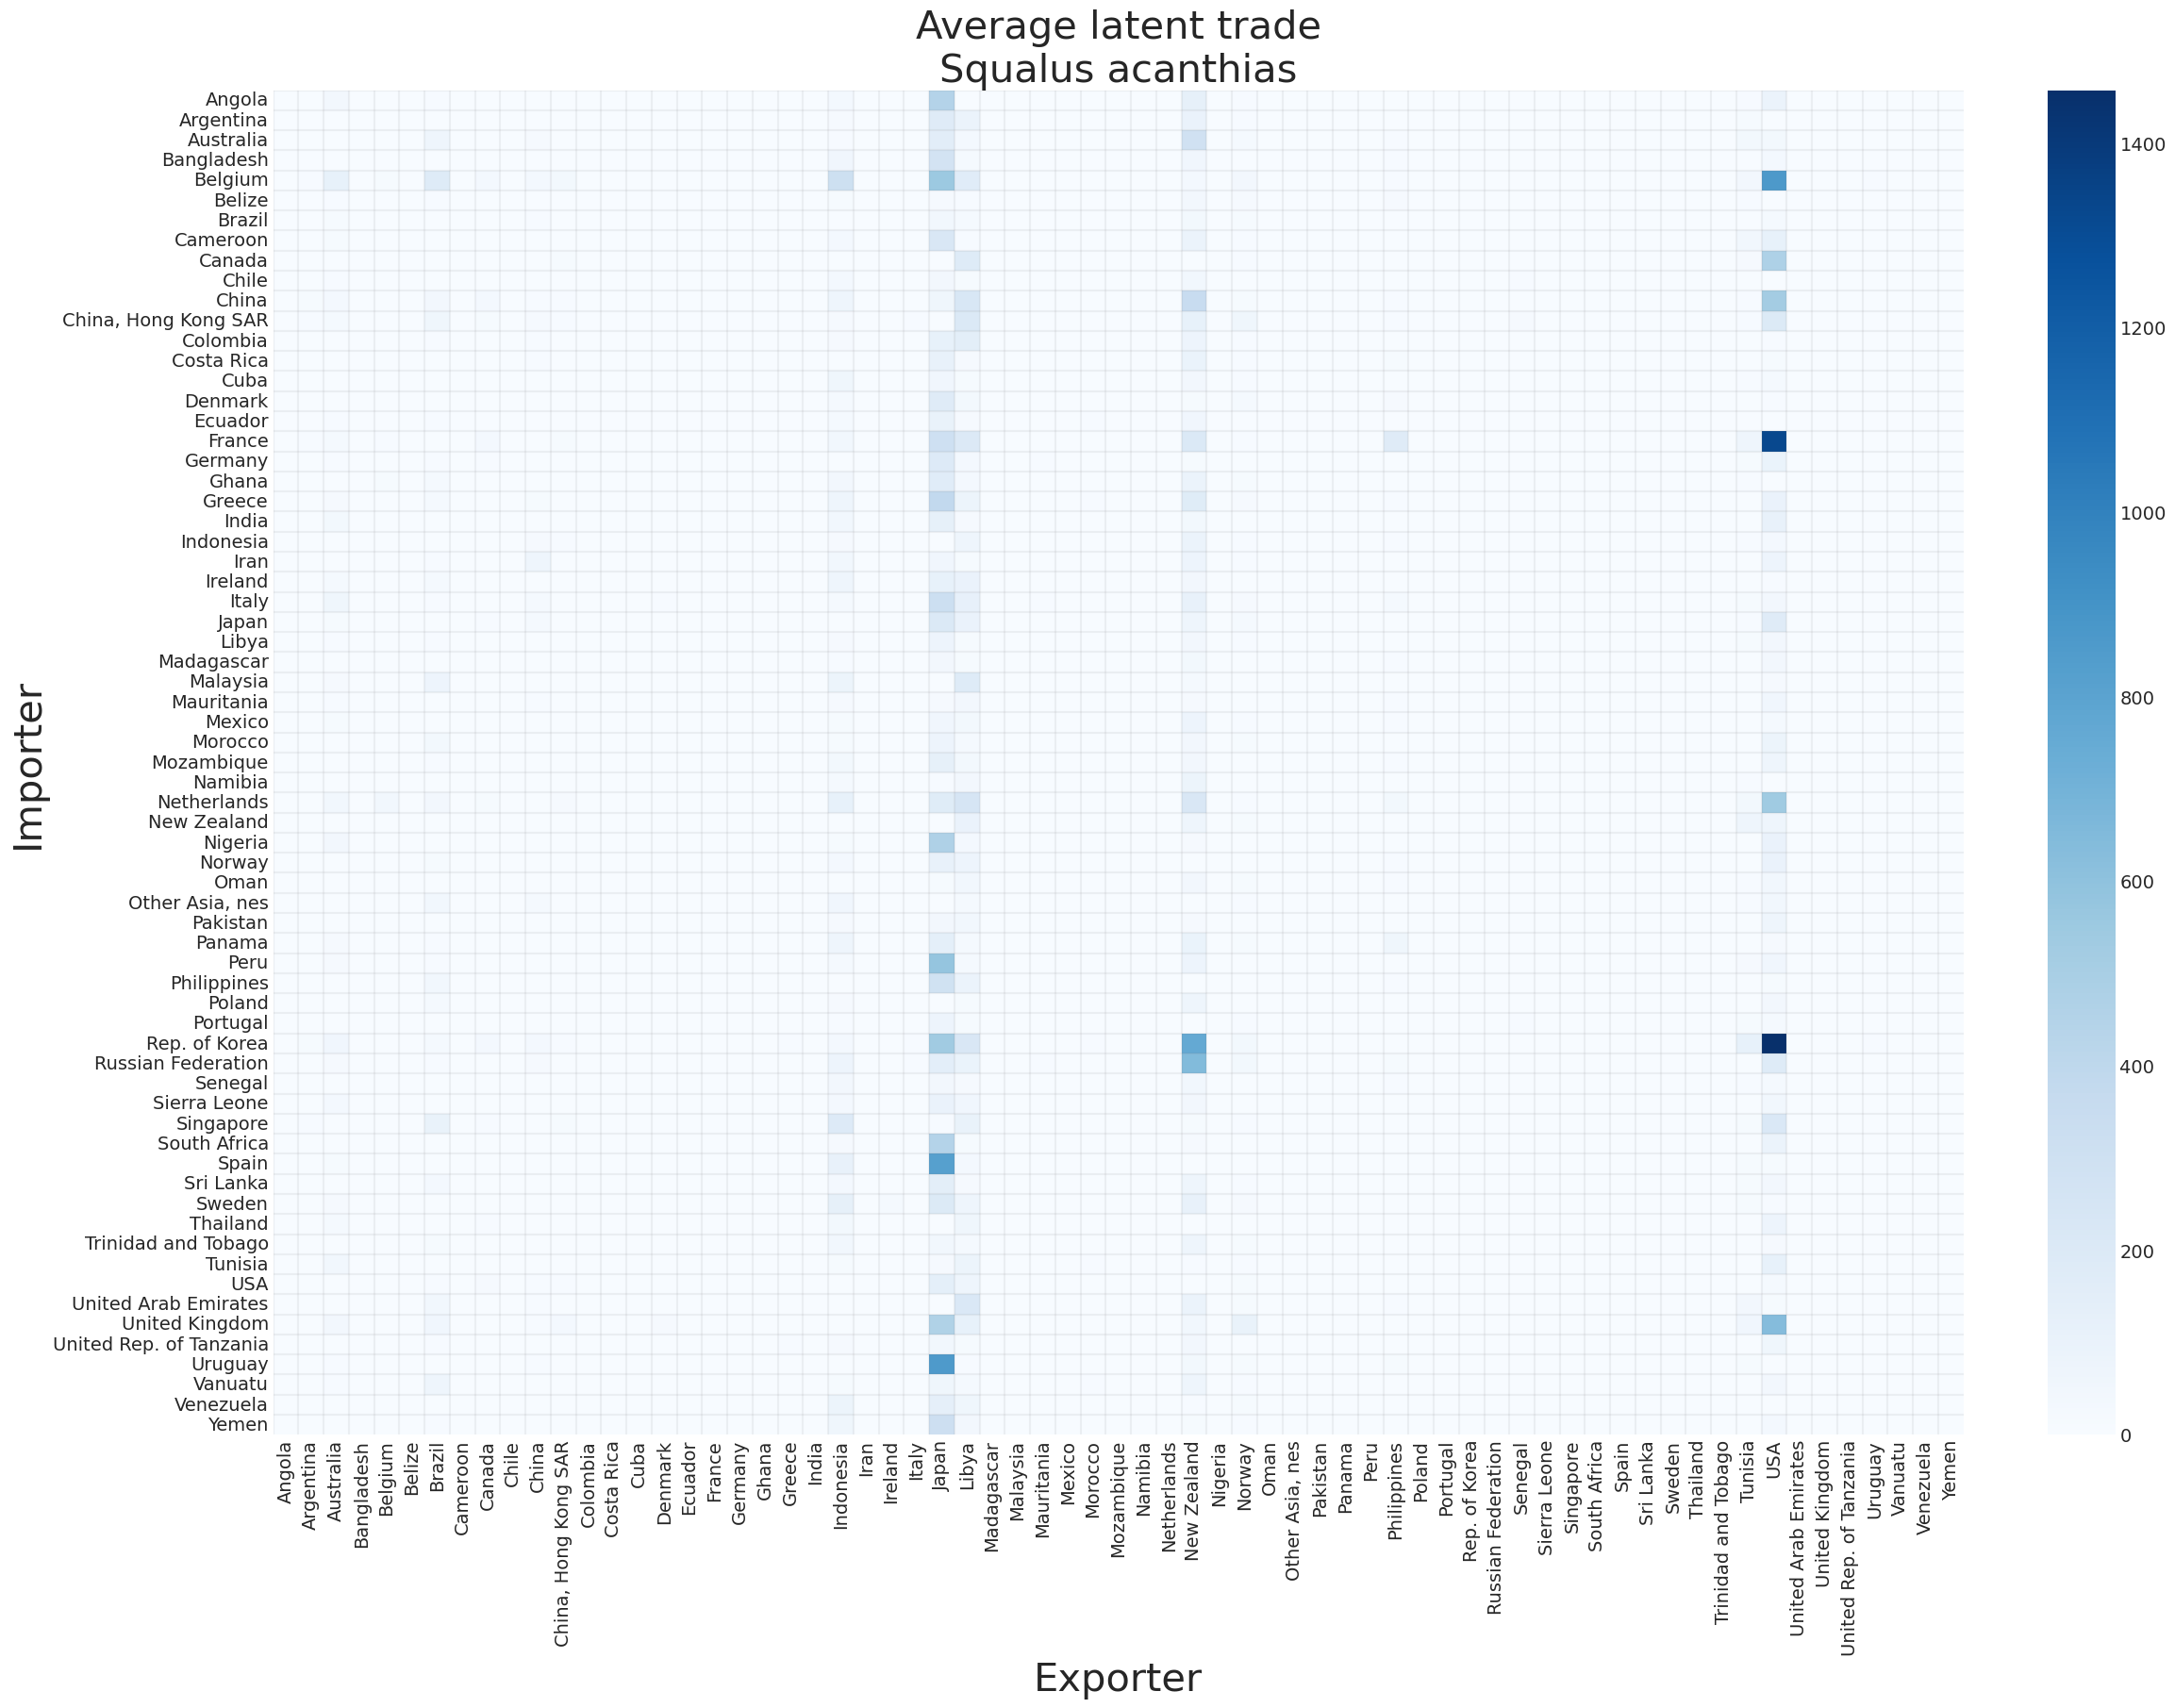

In [133]:
sppx = 'Squalus acanthias'

post_latent_trade = (
    idata_trade_x.posterior["amount_exported"]
    .mean(("chain", "draw"))
    .assign_coords({"Exporter": ("exporter", biggest_countries_long),
                    "Importer": ("importer", biggest_countries_long)})
    .drop_vars(['exporter','importer'])
    .sel(species=sppx)
)

_, ax = plt.subplots(figsize=(23, 18))
sns.heatmap(
    post_latent_trade.to_dataframe().drop(["species"], axis="columns")
    .reset_index().drop(['exporter','importer'],axis=1)
    .set_index(['Exporter','Importer']).unstack()
    .droplevel(0, axis=1)
    .T,
    ax=ax,
    cmap=sns.color_palette("Blues", as_cmap=True),
)
ax.hlines(range(ncou),xmin=0,xmax=ncou,color='grey',alpha=0.1)
ax.vlines(range(ncou),ymin=0,ymax=ncou,color='grey',alpha=0.1)

ax.set_title("Average latent trade\n"+sppx, fontsize=30)
ax.set_xlabel("Exporter", fontsize=30)
ax.set_ylabel("Importer", fontsize=30);